In [1]:
import numpy as np

In [2]:
import os

In [3]:
import ntpath

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col

In [5]:
import scipy.optimize as spopt

In [6]:
from power_spec import power_spec as ps

In [7]:
from cpw_resonator import cpw_resonator as cpw

In [8]:
from qkit.analysis.resonator import Resonator as Resonator

In [9]:
from qkit.analysis import dat_reader as dat

In [10]:
from qkit.analysis.circle_fit.circuit import reflection_singleport as rf_p

In [11]:
import scipy.constants as cs

In [12]:
%matplotlib inline

In [13]:
from qkit.storage import hdf_lib

In [14]:
import random

In [15]:
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage.filters import median_filter

In [16]:
startcolor        =   'black'
midcolor          =   'blue'
endcolor          =   'white'

In [17]:
c_cmap = col.LinearSegmentedColormap.from_list('olive',[startcolor,midcolor,endcolor], N = 256, gamma = 1.0)
cm.register_cmap(cmap = c_cmap)

In [18]:
font = {'weight' : 'normal', 'size' : 22}
plt.rc('font', **font)
labelsize=30

In [19]:
h = cs.h
e = cs.e

In [20]:
phi_0 = cs.codata.value('magn. flux quantum')

In [21]:
R_k = h/(2.*e**2.)

In [407]:
    def _fit_lorentzian_sqr(f_data,amplitude, ignoreslope = False, dB = False, fr = None):
        '''
        - calculates the linear background slope with the first x and the last x percent of the data points
        as the start value for the fit
        - substracts the linear background from the data set to find the real minimum of the resonance (not identical to the 
        overall minimum if the tilt is large and the internal quality factor is high)
        '''
        
 
        amplitude_sqr = gaussian_filter1d(amplitude**2.,6)
        A1a = np.minimum(amplitude_sqr[0],amplitude_sqr[-1])   
  

        if ignoreslope == False:
            m = rf_p._background(f_data, amplitude_sqr, 2., gauss_filter = True)      #x = 2.
            tilt = m*f_data-m*f_data[0]              
            A3a = np.max(amplitude_sqr-tilt)
            fra = f_data[np.argmax(amplitude_sqr-tilt)]
            
        else:
            A3a = np.max(amplitude_sqr)
            fra = f_data[np.argmax(amplitude_sqr)]
            m = 0.                                      #starting value is m = 0.
        
        if fr != None:
            fra = fr
        def residuals(p,x,y):
            A2, Ql = p
            err = y -(A1a+A2*(x-fra)+(A3a)/(1.+4.*Ql**2*((x-fra)/fra)**2))
            return err
        if dB == False:
            p0 = [m, 10000.]
        else:
            p0 = [m,100.]
        p_final = spopt.leastsq(residuals,p0,args=(np.array(f_data),np.array(amplitude_sqr)))
        A2a, Qla = p_final[0]
    
        def residuals2(p,x,y):
            A1, A2, A3, fr, Ql = p
            err = y -(A1+A2*(x-fr)+(A3)/(1.+4.*Ql**2*((x-fr)/fr)**2))
            return err
        p0 = [A1a, A2a, A3a, fra, Qla]
        p_final = spopt.leastsq(residuals2,p0,args=(np.array(f_data),np.array(amplitude_sqr)))
        return p_final[0]

In [312]:
    def _fit_lorentzian(f_data,amplitude, ignoreslope = False, dB = False, fr = None):
        '''
        - calculates the linear background slope with the first x and the last x percent of the data points
        as the start value for the fit
        - substracts the linear background from the data set to find the real minimum of the resonance (not identical to the 
        overall minimum if the tilt is large and the internal quality factor is high)
        '''
        
 
        amplitude = gaussian_filter1d(amplitude,6)
        A1a = np.minimum(amplitude[0],amplitude[-1])   
  

        if ignoreslope == False:
            m = rf_p._background(f_data, amplitude, 2., gauss_filter = True)      #x = 2.
            tilt = m*f_data-m*f_data[0]              
            A3a = np.max(amplitude-tilt)
            fra = f_data[np.argmax(amplitude-tilt)]
            
        else:
            A3a = np.max(amplitude)
            fra = f_data[np.argmax(amplitude)]
            m = 0.                                      #starting value is m = 0.
        
        if fr != None:
            fra = fr
        def residuals(p,x,y):
            A2, Ql = p
            err = y -(A1a+A2*(x-fra)+(A3a)/(1.+4.*Ql**2*((x-fra)/fra)**2))
            return err
        if dB == False:
            p0 = [m, 10000.]
        else:
            p0 = [m,100.]
        p_final = spopt.leastsq(residuals,p0,args=(np.array(f_data),np.array(amplitude)))
        A2a, Qla = p_final[0]
    
        def residuals2(p,x,y):
            A1, A2, A3, fr, Ql = p
            err = y -(A1+A2*(x-fr)+(A3)/(1.+4.*Ql**2*((x-fr)/fr)**2))
            return err
        p0 = [A1a, A2a, A3a, fra, Qla]
        p_final = spopt.leastsq(residuals2,p0,args=(np.array(f_data),np.array(amplitude)))
        return p_final[0]

In [453]:
    def _fit_skewed_lorentzian(f_data,amplitude, ignoreslope = False):
        '''
        - calculates the linear background slope with the first x and the last x percent of the data points
        as the start value for the fit
        - substracts the linear background from the data set to find the real minimum of the resonance (not identical to the 
        overall minimum if the tilt is large and the internal quality factor is high)
        '''
        
        amplitude_sqr = gaussian_filter1d(amplitude**2.,6)
        A1a = np.minimum(amplitude_sqr[0],amplitude_sqr[-1]) 
        #A3a = -(np.max(amplitude_sqr)-np.min(amplitude_sqr))       

        if ignoreslope == False:
            m = rf_p._background(f_data, amplitude_sqr, 2., gauss_filter = True)      #x = 2.
            tilt = m*f_data-m*f_data[0]              
            A3a = np.max(amplitude_sqr-tilt)
            fra = f_data[np.argmax(amplitude_sqr-tilt)]
            
        else:
            A3a = np.max(amplitude_sqr)
            fra = f_data[np.argmax(amplitude_sqr)]
            m = 0.                                      #starting value is m = 0.
            
        def residuals(p,x,y):
            A2, A4, Ql = p
            err = y -(A1a+A2*(x-fra)+(A3a+A4*(x-fra))/(1.+4.*Ql**2*((x-fra)/fra)**2))
            return err
        p0 = [m, 0., 10000.]
        p_final = spopt.leastsq(residuals,p0,args=(np.array(f_data),np.array(amplitude_sqr)))
        A2a, A4a, Qla = p_final[0]
    
        def residuals2(p,x,y):
            A1, A2, A3, A4, fr, Ql = p
            err = y -(A1+A2*(x-fr)+(A3+A4*(x-fr))/(1.+4.*Ql**2*((x-fr)/fr)**2))
            return err
        p0 = [A1a, A2a , A3a, A4a, fra, Qla]
        p_final = spopt.leastsq(residuals2,p0,args=(np.array(f_data),np.array(amplitude_sqr)))
        #A1, A2, A3, A4, fr, Ql = p_final[0]
        #print p_final[0][5]
        return p_final[0]

In [23]:
    def _set_data_range(freq,data, f_min, f_max):
        '''
        cuts the data array to the positions where f>=f_min and f<=f_max in the frequency-array
        the fit functions are fitted only in this area
        the data in the .h5-file is NOT changed
        '''
        if data.ndim == 1:
            return data[(freq >= f_min) & (freq <= f_max)]
        if data.ndim == 2:
            ret_array=np.empty(shape=(data.shape[0],freq.shape[0]),dtype=np.float64)
            for i,a in enumerate(data):
                ret_array[i]=data[i][(freq >= f_min) & (freq <= f_max)]
            return ret_array
            
    def _prepare_f_range(freq,f_min,f_max, array):
        '''
        prepares the data to be fitted:
        f_min (float): lower boundary
        f_max (float): upper boundary
        '''

        ff_min = np.min(freq)
        ff_max = np.max(freq)

        '''
        f_min f_max do not have to be exactly an entry in the freq-array
        '''
        if f_min:
            for freq_1 in freq:
                if freq_1 > f_min:
                    ff_min = freq_1
                    break
        if f_max:
            for freq_1 in freq:
                if freq_1 > f_max:
                    ff_max = freq_1
                    break
                    
        return np.array(_set_data_range(freq,array, ff_min, ff_max))


In [24]:
def mask(freq, f_p, bw, accuracy, Print = False):
    '''this function creates a mask that marks points around the 
    pumpope tone in order to remove them later from raw data
    bw = bandwidth equal to the distance between points in frequency domain'''
    f_low = f_p-accuracy*bw
    f_high = f_p+accuracy*bw
    if Print: 
        print 'f_pump = {} GHz'.format(str(f_p/1e9))
        print r'f_pump - Delta  = {} GHz'.format(str(f_low/1e9))
        print 'f_pump + Delta = {} GHz'.format(str(f_high/1e9))
    m = np.array(freq)
    mask_array = []
    for t in range(len(m)):
        if m[t] < f_low or m[t] > f_high: mask_array.append(False)
        else: mask_array.append(True)
        #mask_array = m[(m[t] <= f_low) & (m[t] >= f_high)]
    return np.array(mask_array)   

In [25]:
def gain_max(freq,amp,mw_pump, power_pump_dim, f_min, f_max):
    '''extracts the maximum gain while removing the pump tone using
    a masked array
    freq: frequency array
    amp: amplitude array
    mw_pump: microwave tone array
    power_pump_dim: pump power array dimension
    f_min: minimal freq
    f_max: maximal freq'''
    gain_m = []
    bw = (freq[-1]-freq[0])/(len(freq))    #distance between two neighbouring points
    fit_freq = _prepare_f_range(freq,f_min, f_max, freq)     
    for i in range(len(mw_pump)):
        gain_max_p = []
        f_p = mw_pump[i]
        for j in range(power_pump_dim):
            amp_buffer = _prepare_f_range(freq,f_min, f_max,amp[j,i,:])
            gain_max_p.append(np.ma.max(np.ma.masked_array(amp_buffer,mask(fit_freq,mw_pump[i], bw,1.))))
        #gain_max_p.append(np.ma.max(np.ma.masked_array(amp[j,i,:],mask(fit_freq,mw_pump[i], bw,1.))))
        gain_m.append(gain_max_p)
    return np.array(gain_m)

In [26]:
def gaussfilter3D(data, numb):
    data_gauss = []
    dim = np.array(data).shape
    if data.ndim == 2:
        for i in range(dim[0]):
                data_gauss.append(gaussian_filter1d(data[i][:],numb))
    if data.ndim == 3:
        for i in range(dim[0]):
            for j in range(dim[1]):
                data_gauss.append(gaussian_filter1d(data[i][j][:],numb))
    return data_gauss

In [27]:
def sweet(power, Gain, mw_freq):
    '''extracts the sweet spot
    power: pump power '''
    p = []
    for i in range(len(mw_freq)):
        p.append(power[np.argmax(Gain[:,i])])
    return p

# resonator parameters: 

In [28]:
cpw_res = cpw(20e-6, 12e-6, 2850e-6, 12e-15)

In [29]:
alpha_0 = np.pi**2.*cpw_res._wresc*50/R_k

In [30]:
cpw_res.get_values()

Ll = 4.38459342705e-07 H/m
Cl = 1.63570516377e-10 F/m
distributed:
L = 1.24960912671e-09 H
C = 4.66175971675e-13 F
R = 0.234241557505 Ohm
lumped element:
Lr = 1.01289500647e-09 H
Cr = 2.33087985838e-13 F
Rr = 14979288.7616 Ohm

Q_int = 117647.058824 
Q_ext = 537.08862226 
Q_load = 534.647819543 

f_res = 10358049260.0 GHz
f_resc = 10101668046.9 GHz 


In [31]:
Ic1 = 7e-6

In [32]:
cpw_res.fres_Wallraff(Ic1, Ic1, 0, 1)

9919257748.2239094

In [33]:
cpw_res.LJ(2*Ic1)

2.350756969259292e-11

In [34]:
cpw_res.LJ(2*Ic1)/cpw_res._L

0.018811938221411924

In [131]:
#powerpath = 'C:/Users/Patrick/Documents/JPA/Ivan/20160728/120610_3D_power_freq_mw_sepc_-25_to-15_step0.1_mw_7.48364349621_to7.49564349621GHz/120610_3D_power_freq_mw_sepc_-25_to-15_step0.1_mw_7.48364349621_to7.49564349621GHz.h5'
#powerpath = 'C:/Users/Patrick/Documents/JPA/Ivan/20160728/120610_3D_power_freq_mw_sepc_-25_to-15_step0.1_mw_7.48364349621_to7.49564349621GHz/120610_3D_power_freq_mw_sepc_-25_to-15_step0.1_mw_7.48364349621_to7.49564349621GHz.h5'
powerpath = 'C:/Users/Patrick/Documents/JPA/Ivan/20160801/085231_3D_power_freq_mw_sepc_-25.0_to-21.0_step0.1_mw_7.4876434962_to7.4926434962GHz/085231_3D_power_freq_mw_sepc_-25.0_to-21.0_step0.1_mw_7.4876434962_to7.4926434962GHz.h5'

In [30]:
data = hdf_lib.Data(path=powerpath)

In [31]:
data

HDF5Data 'data', filename '085231_3D_power_freq_mw_sepc_-25.0_to-21.0_step0.1_mw_7.4876434962_to7.4926434962GHz.h5'

In [32]:
freq = np.array(data['/entry/data0/frequency'])

In [33]:
amp = np.array(data['/entry/data0/amplitude'])

In [34]:
amp.shape

(40, 20, 2001)

In [35]:
phase = np.array(data['/entry/data0/phase'])

In [36]:
power_pump = np.array(data['/entry/data0/power (dbm)'])

In [37]:
mw_pump = np.array(data['/entry/data0/mw_frequency (ghz)'])

In [38]:
X,Y = np.meshgrid(mw_pump, power_pump)

In [39]:
amp.shape

(40, 20, 2001)

In [40]:
fit_freq = _prepare_f_range(freq,freq[0], freq[-1], freq)

In [41]:
fit_amp = _prepare_f_range(freq,freq[0], freq[-1], amp[0,0,:])

In [42]:
fit_amp.shape

(2000,)

In [52]:
p_dim = len(power_pump)

In [53]:
Z = 20.*np.log10(gain_max(freq,amp,mw_pump,p_dim, freq[0],freq[-1]).T)

In [54]:
p_sweet = sweet(power_pump, Z, mw_pump)

In [59]:
np.extract( power_pump == p_sweet[1], np.arange(0,len(power_pump),1))

array([30])

In [60]:
np.extract(power_pump == p_sweet[1], power_pump)

array([-22.], dtype=float32)

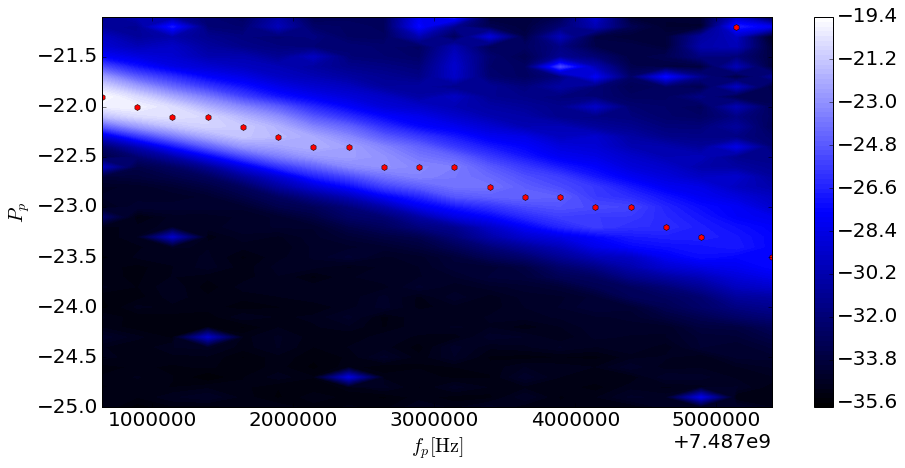

In [63]:
fig, axes = plt.subplots(figsize=(15,7))
p = axes.contourf(X,Y,Z, 100, cmap = c_cmap)
cb = fig.colorbar(p, ax = axes)
axes.set_ylabel(r'$P_p$')
axes.plot(mw_pump, np.array(p_sweet), 'h',  color = 'red')
#plt.setp(axes, yticks=[-2.*np.pi,-np.pi, -np.pi/2, 0., np.pi/2., np.pi, 2.*np.pi], yticklabels = [r'$-2\pi$',r'$-\pi}$',r'$-\frac{\pi}{2}$', '0',  r'$\frac{\pi}{2}$', r'$\pi$', r'$2\pi$'])
#axes.set_xlabel(r'$F = \frac{\pi \Phi_{ext}}{\Phi_0}$')
axes.set_xlabel(r'$f_p [\mathrm{Hz}]$')
#cb.set_ticks([-8,-4,0,4,8])

In [64]:
c = color=cm.rainbow(np.linspace(0,1,20))

In [65]:
color = ['blue', 'red', 'green','brown', 'purple', 'cyan', 'black', 'pink', 'orange', 'silver','skyblue','green']

7487670916.3 -2407.16957623
7487934955.28 -2345.31336341
7488190815.51 -2280.55424277
7488479584.21 -2032.69443779
7488703172.38 -1992.9057245
7488967342.21 -1954.42752686
7489224603.35 -1906.55622512
7489465613.21 -1732.67548131
7489724155.45 -1813.85415446
7490000795.19 -1637.25697427
7490247395.86 -1506.30798636
7490526259.1 -1567.8066545
7490775598.33 -1541.12255283
7491033490.78 -1425.44842268
7491271952.54 -1404.68114526
7491580577.84 -1298.48937521
7491815055.8 -1327.97436723
7492140857.72 -1294.56671088
7499338458.58 317.1765223
7492547850.62 1241.56595433


(7458000000.0, 7522040000.0)

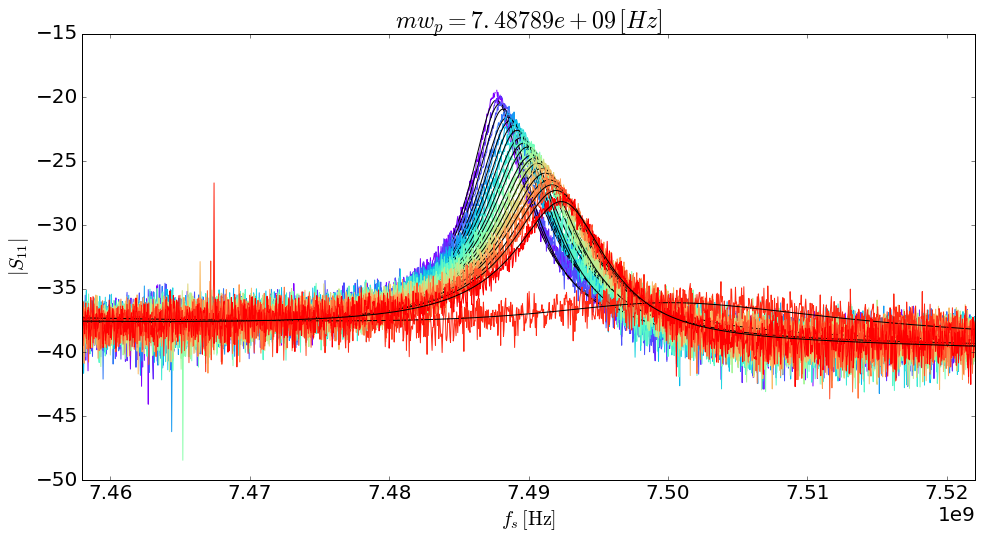

In [66]:
a = 1
#sweet spots only
f_min = freq[200]
f_max = freq[-200]
fit_freq = _prepare_f_range(freq,f_min, f_max,freq)
fig, axes = plt.subplots(figsize = (16,8))
c = color=cm.rainbow(np.linspace(0,1,len(mw_pump)))
indices = np.arange(0,len(power_pump),1)
for j in range(len(mw_pump)):
    #axes.axvline(mw_pump[j], color = 'yellow', lw = 1.)
    mask_p = power_pump == p_sweet[j]
    i = int(np.extract(mask_p,indices)) 
    amp_buffer = _prepare_f_range(freq,f_min, f_max,gaussian_filter1d(amp[i,j,:],0))
    A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(fit_freq,amp_buffer, ignoreslope = True)
    print fr, Ql
    lorentzian = (A1+A2*(fit_freq-fr)+(A3+A4*(fit_freq-fr))/(1.+4.*Ql**2*((fit_freq-fr)/fr)**2))
    axes.plot(fit_freq,20.*np.log10(np.ma.masked_array(amp_buffer, mask(fit_freq,mw_pump[j], (freq[-1]-freq[0])/(len(freq)),1.))), label =r'$P_p = {}$'.format(str(power_pump[i])), color = c[j])
    axes.plot(fit_freq, 20.*np.log10(lorentzian), color = 'black')
axes.set_title(r'$mw_p = {}\,[Hz]$'.format(str(mw_pump[a])))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
axes.set_xlim(f_min,f_max)
#axes.legend()

In [67]:
X1,Y1 = np.meshgrid(freq, mw_pump)

In [68]:
p_p = 30

In [69]:
Z1 = 20.*np.log10(amp[p_p])

In [70]:
power_pump[p_p]

-22.0

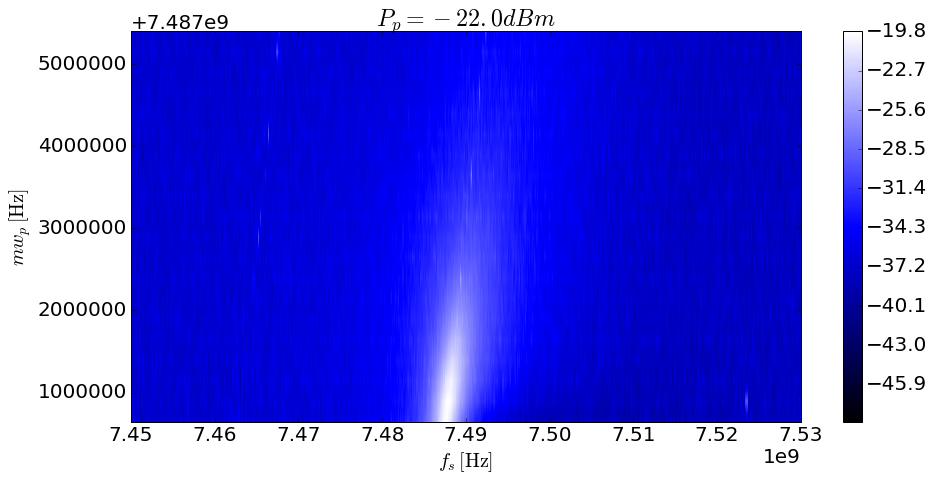

In [71]:
fig, axes = plt.subplots(figsize=(15,7))
p = axes.contourf(X1,Y1,Z1, 300, cmap = c_cmap)
cb = fig.colorbar(p, ax = axes)
axes.set_ylabel(r'$mw_p\, [\mathrm{Hz}]$')
axes.set_title(r'$P_p = {} dBm$'.format(str(power_pump[p_p])))
#plt.setp(axes, yticks=[-2.*np.pi,-np.pi, -np.pi/2, 0., np.pi/2., np.pi, 2.*np.pi], yticklabels = [r'$-2\pi$',r'$-\pi}$',r'$-\frac{\pi}{2}$', '0',  r'$\frac{\pi}{2}$', r'$\pi$', r'$2\pi$'])
#axes.set_xlabel(r'$F = \frac{\pi \Phi_{ext}}{\Phi_0}$')
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
#cb.set_ticks([-8,-4,0,4,8])

In [72]:
X2,Y2 = np.meshgrid(freq, power_pump)

In [73]:
p_p = int(1)

In [74]:
amp[:,0,:].shape

(40, 2001)

In [75]:
Z2 = np.log10(amp[p_p])

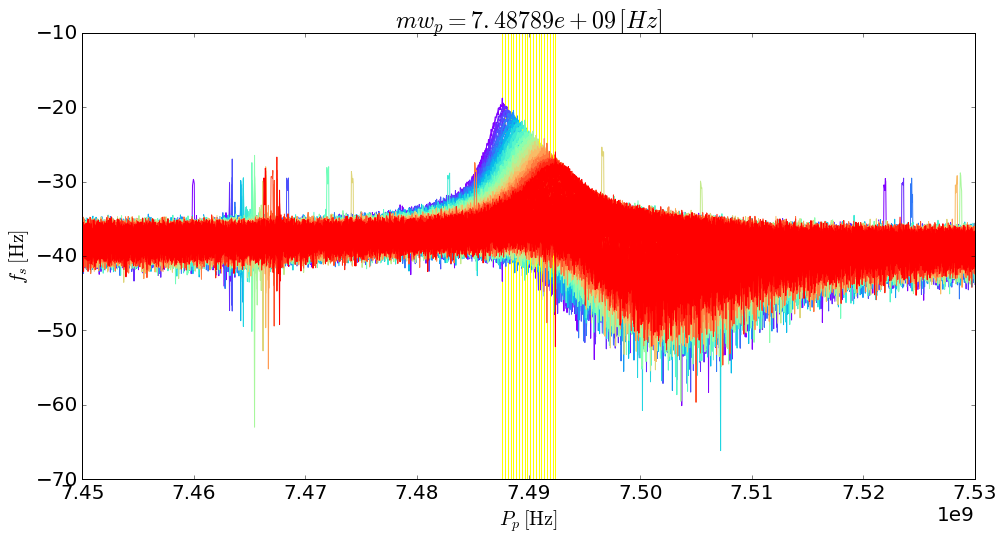

In [76]:
a = 1
fig, axes = plt.subplots(figsize = (16,8))
for j in range(len(mw_pump)):
    axes.axvline(mw_pump[j], color = 'yellow', lw = 1.)
    for i in range(len(power_pump)):
        axes.plot(freq,20.*np.log10(amp[i,j,:]), label =r'$P_p = {}$'.format(str(power_pump[i])), color = c[j])
axes.set_title(r'$mw_p = {}\,[Hz]$'.format(str(mw_pump[a])))
axes.set_ylabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_xlabel(r'$P_p\, [\mathrm{Hz}]$')
#axes.legend()

(7458000000.0, 7522040000.0)

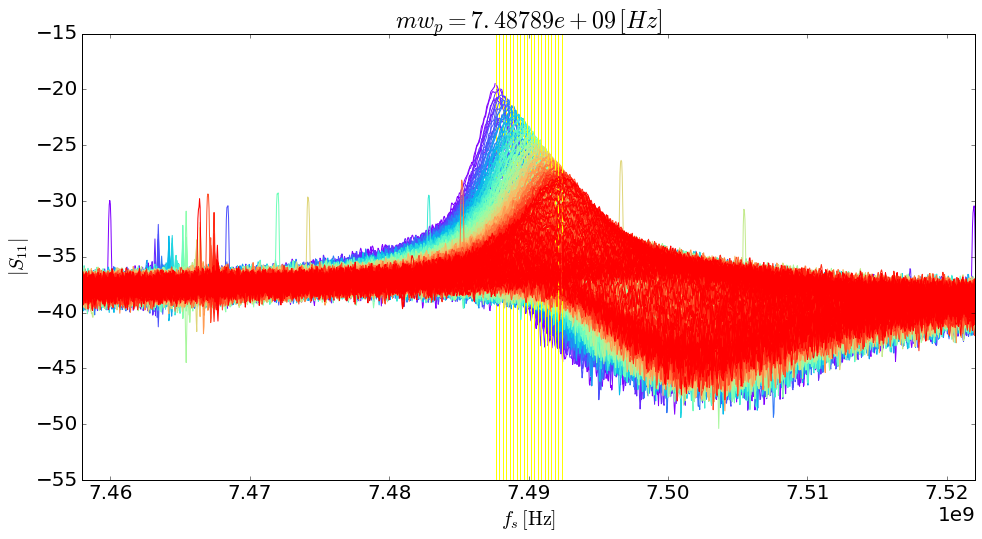

In [77]:
a = 1
f_min = freq[200]
f_max = freq[-200]
fit_freq = _prepare_f_range(freq,f_min, f_max,freq)
fig, axes = plt.subplots(figsize = (16,8))
for j in range(len(mw_pump)):
    axes.axvline(mw_pump[j], color = 'yellow', lw = 1.)
    for i in range(len(power_pump)):
        amp_buffer = _prepare_f_range(freq,f_min, f_max,gaussian_filter1d(amp[i,j,:],1))
        axes.plot(fit_freq,20.*np.log10(np.ma.masked_array(amp_buffer, mask(fit_freq,mw_pump[j], (freq[-1]-freq[0])/(len(freq)),1.))), label =r'$P_p = {}$'.format(str(power_pump[i])), color = c[j])
axes.set_title(r'$mw_p = {}\,[Hz]$'.format(str(mw_pump[a])))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
axes.set_xlim(f_min,f_max)

In [78]:
amp.shape

(40, 20, 2001)

In [80]:
z_data_raw = amp*np.exp(1.j*phase)

In [81]:
z_data_raw.shape

(40, 20, 2001)

In [83]:
A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(freq,np.absolute(z_data_raw[20,19,:]), ignoreslope = True)

In [84]:
lorentzian = (A1+A2*(freq-fr)+(A3+A4*(freq-fr))/(1.+4.*Ql**2*((freq-fr)/fr)**2))

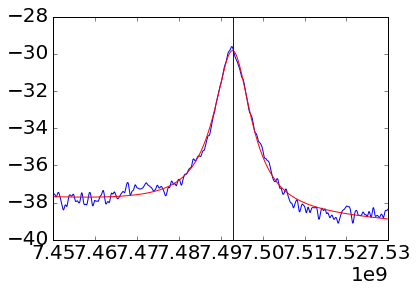

In [85]:
plt.plot(freq, 20.*np.log10(gaussian_filter1d(np.absolute(z_data_raw[20,19,:]),6)))
plt.plot(freq, 20.*np.log10(lorentzian), color = 'red')
plt.axvline(fr)

In [86]:
fr

7492880882.6829786

In [87]:
#powerpath = 'C:/Users/Patrick/Documents/JPA/Ivan/20160728/120610_3D_power_freq_mw_sepc_-25_to-15_step0.1_mw_7.48364349621_to7.49564349621GHz/120610_3D_power_freq_mw_sepc_-25_to-15_step0.1_mw_7.48364349621_to7.49564349621GHz.h5'
#powerpath = 'C:/Users/Patrick/Documents/JPA/Ivan/20160728/120610_3D_power_freq_mw_sepc_-25_to-15_step0.1_mw_7.48364349621_to7.49564349621GHz/120610_3D_power_freq_mw_sepc_-25_to-15_step0.1_mw_7.48364349621_to7.49564349621GHz.h5'
powerpath2 = 'C:/Users/Patrick/Documents/JPA/Ivan/20160801/125741_3D_power_freq_mw_sepc_-25.0_to-20.5_step0.1_mw_7.4806434962_to7.4926434962GHz/125741_3D_power_freq_mw_sepc_-25.0_to-20.5_step0.1_mw_7.4806434962_to7.4926434962GHz.h5'

In [88]:
data2 = hdf_lib.Data(path=powerpath2)
freq2 = np.array(data2['/entry/data0/frequency'])
amp2 = np.array(data2['/entry/data0/amplitude'])
phase2 = np.array(data2['/entry/data0/phase'])
power_pump2 = np.array(data2['/entry/data0/power (dbm)'])
mw_pump2 = np.array(data2['/entry/data0/mw_frequency (ghz)'])
X21,Y21 = np.meshgrid(mw_pump2, power_pump2)
fit_freq2 = _prepare_f_range(freq2,freq2[0], freq2[-1], freq2)
fit_amp2 = _prepare_f_range(freq2,freq2[0], freq2[-1], amp2[0,0,:])

In [89]:
amp2.shape

(45, 48, 2001)

In [90]:
Z22 = 20.*np.log10(gain_max(freq2,amp2, mw_pump2,len(power_pump2), freq2[0],freq2[-1]).T)
#p_sweet2 = sweet(power_pump2, Z21, mw_pump2)

In [91]:
Z22.shape

(45, 48)

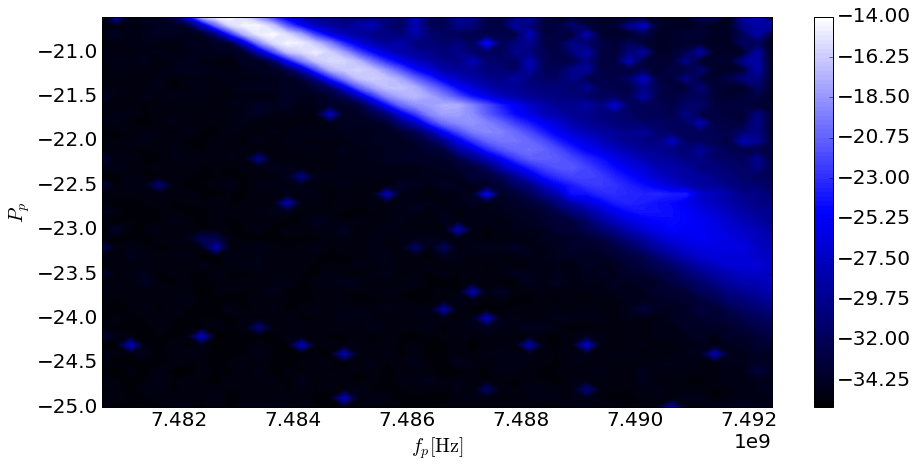

In [92]:
fig, axes = plt.subplots(figsize=(15,7))
p = axes.contourf(X21,Y21,Z22, 100, cmap = c_cmap)
cb = fig.colorbar(p, ax = axes)
axes.set_ylabel(r'$P_p$')
#axes.plot(mw_pump2, np.array(p_sweet2), 'h',  color = 'red')
#plt.setp(axes, yticks=[-2.*np.pi,-np.pi, -np.pi/2, 0., np.pi/2., np.pi, 2.*np.pi], yticklabels = [r'$-2\pi$',r'$-\pi}$',r'$-\frac{\pi}{2}$', '0',  r'$\frac{\pi}{2}$', r'$\pi$', r'$2\pi$'])
#axes.set_xlabel(r'$F = \frac{\pi \Phi_{ext}}{\Phi_0}$')
axes.set_xlabel(r'$f_p [\mathrm{Hz}]$')
#cb.set_ticks([-8,-4,0,4,8])

In [93]:
p_sweet2 = sweet(power_pump2, Z22, mw_pump2)

7488386413.85 1830.07668652
7493528528.67 310.606085301
7466550179.53 13364.0268773
7492429779.67 -332.881413498
7502775373.04 413.983121415
7487999000.72 -297.266623179
7482268652.45 7962.42241175
7482560546.82 9361.86841217
7482705226.09 9131.41364785
7482857554.28 8154.87114666
7483141463.19 7853.20441365
7483361982.44 7054.54112191
7483621592.08 6780.41487842
7483953959.07 6861.45499825
7484141066.06 5961.82352984
7484376247.91 5573.94622936
7484652844.55 5262.71031623
7484873596.33 4629.62734007
7485147869.94 4452.84176088
7485413361.2 4306.75368437
7485635543.53 3711.79066962
7485898255.93 3653.3382048
7486149252.2 3449.89216256
7486406045.22 2964.05520151
7486389605.5 2904.17303086
7486642012.57 2928.2693273
7487178506.31 2741.8901322
7487443433.87 2671.69772352
7487672325.38 -2417.72144772
7487930645.62 -2325.08535627
7488201197.29 -2252.34082473
7488457213.75 -2041.59993367
7488694045.91 -1974.50967219
7488959711.46 -1926.89007592
7489231194.55 -1894.20202334
7489485549.14 -17

(7458000000.0, 7522040000.0)

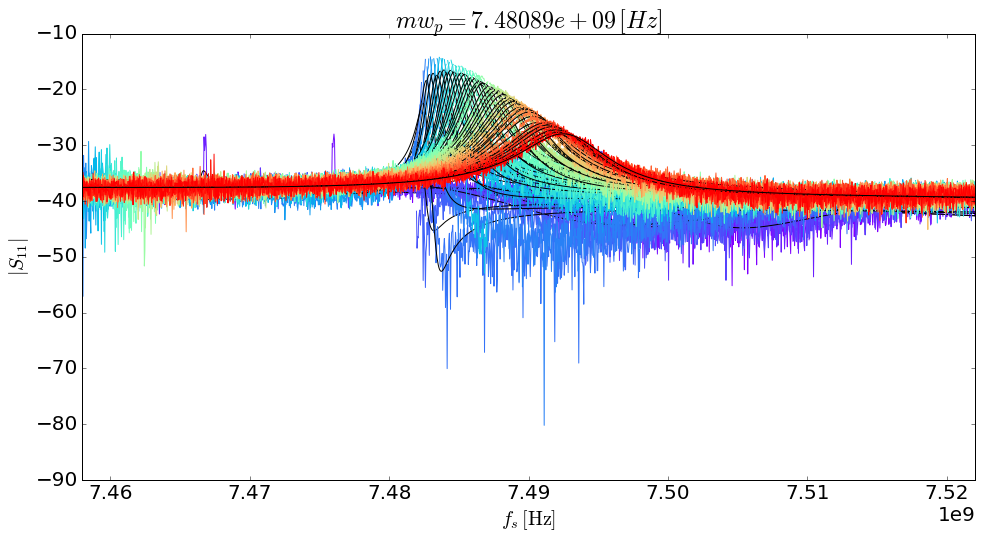

In [94]:
a = 1
#sweet spots only
f_min = freq2[200]
f_max = freq2[-200]
fit_freq2 = _prepare_f_range(freq2,f_min, f_max,freq2)
fig, axes = plt.subplots(figsize = (16,8))
c = color=cm.rainbow(np.linspace(0,1,len(mw_pump2)))
indices = np.arange(0,len(power_pump2),1)
for j in range(len(mw_pump2)):
    #axes.axvline(mw_pump[j], color = 'yellow', lw = 1.)
    mask_p = power_pump2 == p_sweet2[j]
    i = int(np.extract(mask_p,indices)) 
    amp_buffer = _prepare_f_range(freq2,f_min, f_max,gaussian_filter1d(amp2[i,j,:],0))
    A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(fit_freq,amp_buffer, ignoreslope = True)
    print fr, Ql
    lorentzian = (A1+A2*(fit_freq-fr)+(A3+A4*(fit_freq2-fr))/(1.+4.*Ql**2*((fit_freq2-fr)/fr)**2))
    axes.plot(fit_freq2,20.*np.log10(np.ma.masked_array(amp_buffer, mask(fit_freq2,mw_pump2[j], (freq2[-1]-freq2[0])/(len(freq2)),1.))), label =r'$P_p = {}$'.format(str(power_pump2[i])), color = c[j])
    axes.plot(fit_freq2, 20.*np.log10(lorentzian), color = 'black')
axes.set_title(r'$mw_p = {}\,[Hz]$'.format(str(mw_pump2[a])))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
axes.set_xlim(f_min,f_max)
#axes.legend()

In [95]:
mw_min = mw_pump2[0]
mw_max = mw_pump2[-1]
fit_mw_pump2 = _prepare_f_range(mw_pump2, mw_min, mw_max, mw_pump2)

7486228649.05 487.807590131
7483858893.62 6235.27488911
7484098058.53 6455.61772377
7484216362.4 6243.13287615
7484381220.89 5559.43166084
7484631206.72 4616.14859635
7484943470.89 3126.81222868
7485352760.17 1569.24175366
7485811571.55 904.46124982
7486379379.17 660.968169882
7486848038.98 -561.020996848
7487270593.39 497.970917128
7487459451.04 441.887789985
7488135433.21 414.952410753
7488502514.59 398.527899541
7489863078.37 359.706806837
7488861915.13 370.803613523
7490525308.05 354.274631679
7491374530.2 342.607875701
7493345020.91 315.847857536
7491900167.87 302.242497586
7493566084.06 313.728418752
7494747653.36 296.7730724
7495557819.54 -311.506412275
7496224678.26 317.058855035
7498237862.85 -309.170720477
7498597118.52 316.147783366
7499619304.72 316.817783053
7498589196.34 -302.315039268
7499650903.26 327.45682451
7499370861.24 326.63675599
7500146677.95 -377.865765972
7499311309.59 -348.101909666
7500278028.53 315.271566384


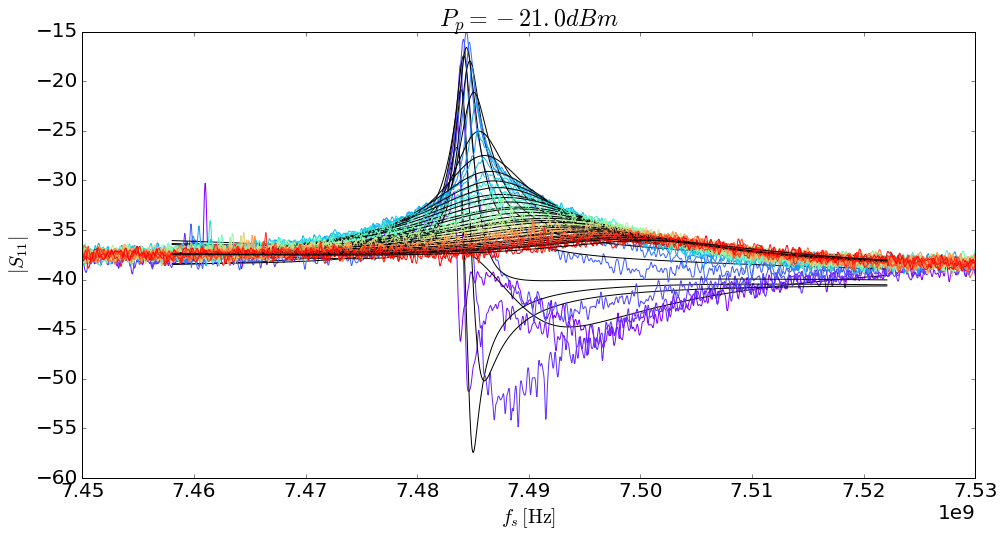

In [96]:
a = 1
#sweet spots only
fig, axes = plt.subplots(figsize = (16,8))
mask_p = power_pump2 == -21.0
i = int(np.extract(mask_p,indices))
mw_min = mw_pump2[10]
mw_max = mw_pump2[-5]
fit_mw_pump2 = _prepare_f_range(mw_pump2, mw_min, mw_max, mw_pump2)
c = color=cm.rainbow(np.linspace(0,1,len(fit_mw_pump2)))
for j in range(len(fit_mw_pump2)):
    mask_mw = mw_pump2 == fit_mw_pump2[j]
    r = int(np.extract(mask_mw,indices)) 
    #axes.axvline(mw_pump2[j], color = 'yellow', lw = 1.)
    A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(freq2,amp2[i,r,:], ignoreslope = True)
    print fr, Ql
    lorentzian = (A1+A2*(fit_freq2-fr)+(A3+A4*(fit_freq2-fr))/(1.+4.*Ql**2*((fit_freq2-fr)/fr)**2))
    axes.plot(freq2,20.*np.log10(gaussian_filter1d(amp2[i,r,:],2)), label =r'$P_p = {}$'.format(str(power_pump2[i])), color = c[j])
    axes.plot(fit_freq2, 20.*np.log10(lorentzian), color = 'black')
axes.set_title(r'$P_p = {} dBm$'.format(str(-21.0)))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
#axes.legend()

7484098058.53 6455.61772377


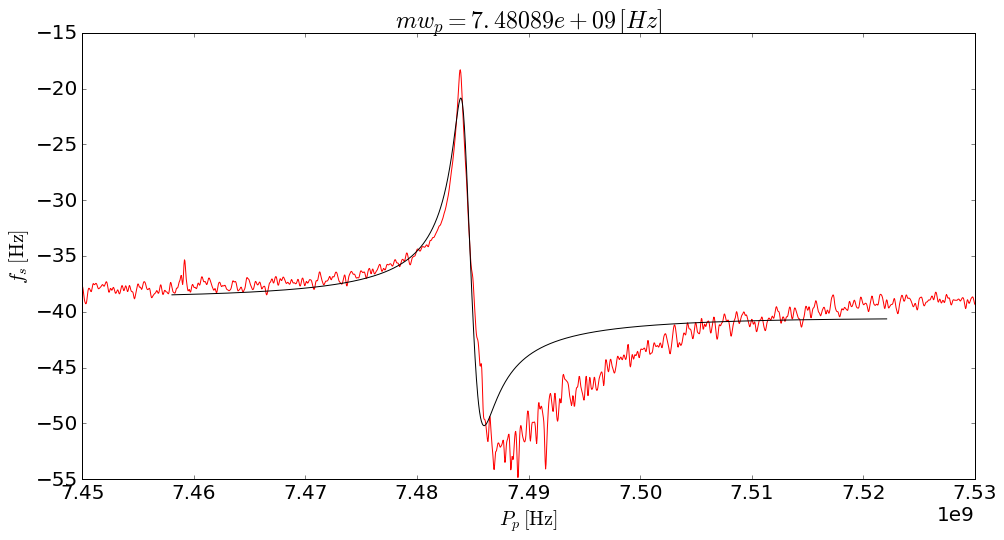

In [97]:
a = 1
#sweet spots only
fig, axes = plt.subplots(figsize = (16,8))
mask_p = power_pump2 == -21.0
i = int(np.extract(mask_p,indices))
mw_min = mw_pump2[10]
mw_max = mw_pump2[-5]
fit_mw_pump2 = _prepare_f_range(mw_pump2, mw_min, mw_max, mw_pump2)
c = color=cm.rainbow(np.linspace(0,1,len(fit_mw_pump2)))
r = 13
#axes.axvline(mw_pump2[j], color = 'yellow', lw = 1.)
A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(freq2,amp2[i,r,:], ignoreslope = True)
print fr, Ql
lorentzian = (A1+A2*(fit_freq2-fr)+(A3+A4*(fit_freq2-fr))/(1.+4.*Ql**2*((fit_freq2-fr)/fr)**2))
axes.plot(freq2,20.*np.log10(gaussian_filter1d(amp2[i,r,:],2)), label =r'$P_p = {}$'.format(str(power_pump2[i])), color = c[j])
axes.plot(fit_freq2, 20.*np.log10(lorentzian), color = 'black')
axes.set_title(r'$mw_p = {}\,[Hz]$'.format(str(mw_pump2[a])))
axes.set_ylabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_xlabel(r'$P_p\, [\mathrm{Hz}]$')
#axes.legend()

In [35]:
#powerpath = 'C:/Users/Patrick/Documents/JPA/Ivan/20160728/120610_3D_power_freq_mw_sepc_-25_to-15_step0.1_mw_7.48364349621_to7.49564349621GHz/120610_3D_power_freq_mw_sepc_-25_to-15_step0.1_mw_7.48364349621_to7.49564349621GHz.h5'
#powerpath = 'C:/Users/Patrick/Documents/JPA/Ivan/20160728/120610_3D_power_freq_mw_sepc_-25_to-15_step0.1_mw_7.48364349621_to7.49564349621GHz/120610_3D_power_freq_mw_sepc_-25_to-15_step0.1_mw_7.48364349621_to7.49564349621GHz.h5'
powerpath3 = 'C:/Users/Patrick/Documents/JPA/Ivan/20160801/184542_3D_3D_Global_power_freq_mw_spec_-25.0_to-19.0_step0.05_mw_7.4806434962_to7.4936434962GHz/184542_3D_3D_Global_power_freq_mw_spec_-25.0_to-19.0_step0.05_mw_7.4806434962_to7.4936434962GHz.h5'

In [36]:
data3 = hdf_lib.Data(path=powerpath3)
freq3 = np.array(data3['/entry/data0/frequency'])
amp3 = np.array(data3['/entry/data0/amplitude'])
phase3 = np.array(data3['/entry/data0/phase'])
power_pump3 = np.array(data3['/entry/data0/power (dbm)'])
mw_pump3 = np.array(data3['/entry/data0/mw_frequency (ghz)'])
X31,Y31 = np.meshgrid(mw_pump3, power_pump3)
fit_freq3 = _prepare_f_range(freq3,freq3[0], freq3[-1], freq3)
fit_amp3 = _prepare_f_range(freq3,freq3[0], freq3[-1], amp3[0,0,:])

In [37]:
z_data_raw = amp3[0,0,:]*np.exp(1.j*phase3[0,0,:])

In [38]:
cf = rf_p(freq3, z_data_raw)

In [39]:
cf.autofit('overcoupled')

fr (phase derivation) = 7506800000.0
agebraic r0: 0.00974039711414
iterative r0: 0.0090137594132
zc = (-0.00346804744954+0.000733843551019j)
calibration: Theta0 -5.88032255341
agebraic r0: 0.78656504689
iterative r0: 0.74562489863
-2.97246024716


C:\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


phi_0 = 0.169132406434


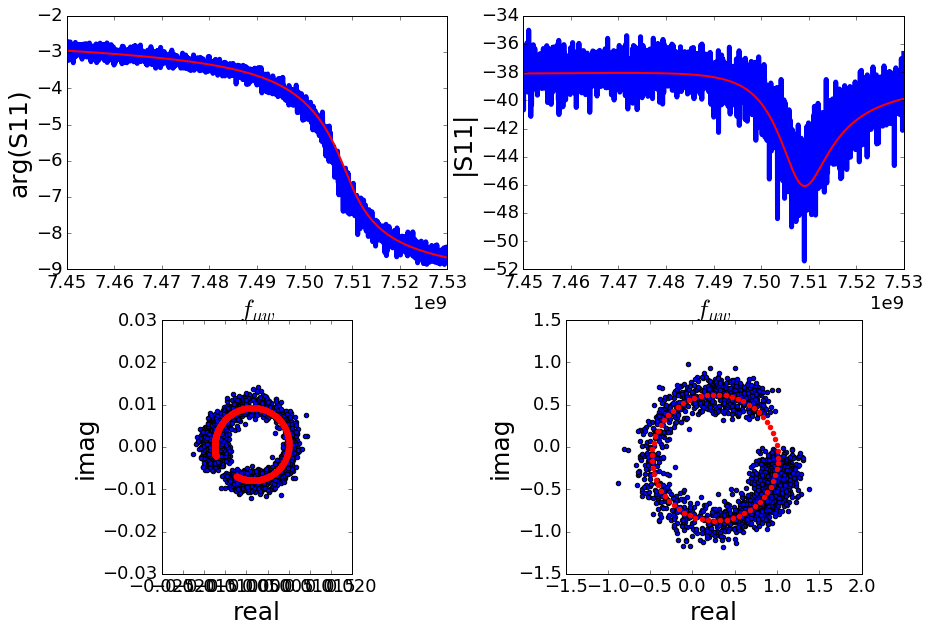

In [40]:
cf.plot_all()

In [41]:
cf.fitresults

{'Qc': 502.04953972003449,
 'Qc_err': 17.031147129312135,
 'Qi': 1471.6087979720089,
 'Qi_err': 218.43290353288452,
 'Ql': 374.3406371610206,
 'Ql_err': 4.719291236326459,
 'chi_square': 0.028512948202133695,
 'fr': 7504916665.8073397,
 'fr_err': 145880.51022078187,
 'phi_0': 0.16913240643363275,
 'phi_0_err': 0.016341601188594127,
 'theta0': -2.9725229998974156}

In [42]:
Ql = cf.fitresults['Ql']
fres = cf.fitresults['fr']
Gamma = 2.*np.pi*fres/Ql
print Ql, fres/10**9., Gamma/10**6.
Ql2 = 392
Gamma2 = 2.*np.pi*fres/Ql2
print Gamma2

374.340637161 7.50491666581 125.96757457
120292811.546


In [43]:
def gaussfilter3D(data, numb):
    data_gauss = []
    dim = np.array(data).shape
    if data.ndim == 2:
        for i in range(dim[0]):
                data_gauss.append(gaussian_filter1d(data[i][:],numb))
    if data.ndim == 3:
        for i in range(dim[0]):
            data_mw = []
            for j in range(dim[1]):
                data_mw.append(gaussian_filter1d(data[i][j][:],numb))
            data_gauss.append(data_mw)
    return data_gauss

In [44]:
amp3_gauss = gaussfilter3D(amp3, 3)

In [45]:
np.array(amp3_gauss).shape

(120, 87, 2001)

In [46]:
Z3 = 20.*np.log10(gain_max(freq3,amp3, mw_pump3,len(power_pump3), freq3[0],freq3[-1]).T)
Z3_gauss = 20.*np.log10(gain_max(freq3,np.array(amp3_gauss), mw_pump3,len(power_pump3), freq3[0],freq3[-1]).T)
#p_sweet2 = sweet(power_pump2, Z21, mw_pump2)

In [47]:
p_sweet3 = sweet(power_pump3, Z3, mw_pump3)

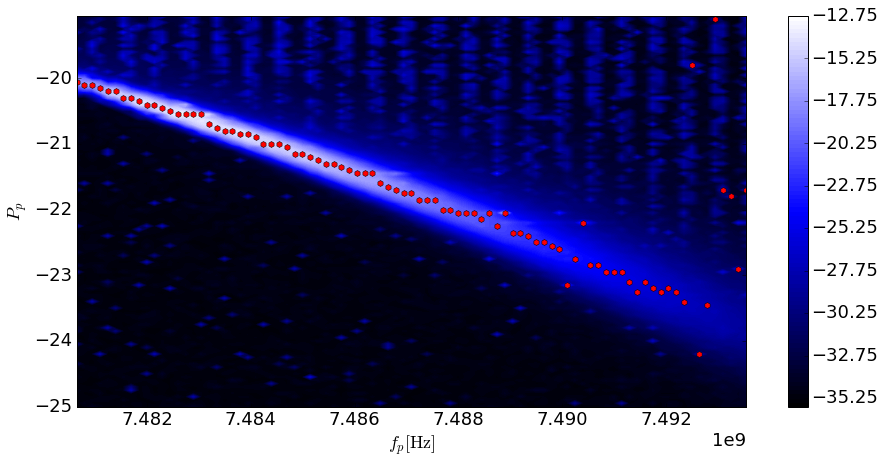

In [48]:
fig, axes = plt.subplots(figsize=(15,7))
p = axes.contourf(X31,Y31,Z3, 100, cmap = c_cmap)
cb = fig.colorbar(p, ax = axes)
axes.set_ylabel(r'$P_p$')
axes.plot(mw_pump3, p_sweet3,'h',  color = 'red', lw = 0.5)
axes.plot()
#axes.plot(mw_pump2, np.array(p_sweet2), 'h',  color = 'red')
#plt.setp(axes, yticks=[-2.*np.pi,-np.pi, -np.pi/2, 0., np.pi/2., np.pi, 2.*np.pi], yticklabels = [r'$-2\pi$',r'$-\pi}$',r'$-\frac{\pi}{2}$', '0',  r'$\frac{\pi}{2}$', r'$\pi$', r'$2\pi$'])
#axes.set_xlabel(r'$F = \frac{\pi \Phi_{ext}}{\Phi_0}$')
axes.set_xlabel(r'$f_p [\mathrm{Hz}]$')
#cb.set_ticks([-8,-4,0,4,8])

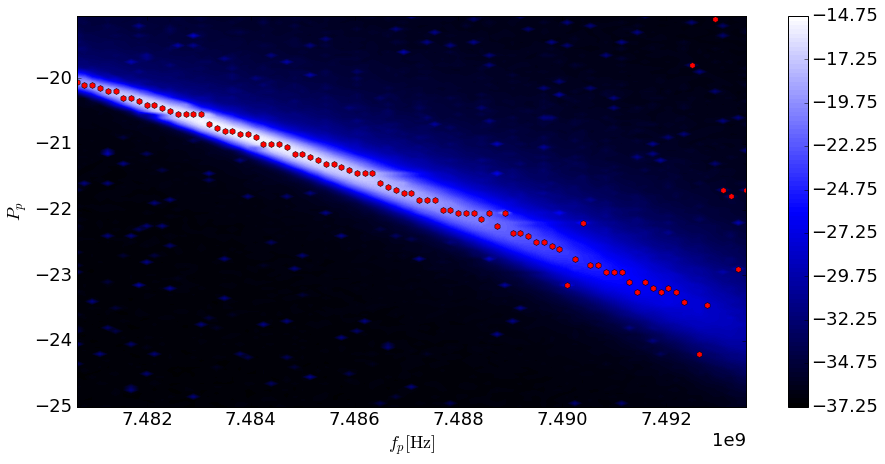

In [49]:
fig, axes = plt.subplots(figsize=(15,7))
p = axes.contourf(X31,Y31,Z3_gauss, 100, cmap = c_cmap)
cb = fig.colorbar(p, ax = axes)
axes.set_ylabel(r'$P_p$')
axes.plot(mw_pump3, p_sweet3,'h',  color = 'red', lw = 0.5)
axes.plot()
#axes.plot(mw_pump2, np.array(p_sweet2), 'h',  color = 'red')
#plt.setp(axes, yticks=[-2.*np.pi,-np.pi, -np.pi/2, 0., np.pi/2., np.pi, 2.*np.pi], yticklabels = [r'$-2\pi$',r'$-\pi}$',r'$-\frac{\pi}{2}$', '0',  r'$\frac{\pi}{2}$', r'$\pi$', r'$2\pi$'])
#axes.set_xlabel(r'$F = \frac{\pi \Phi_{ext}}{\Phi_0}$')
axes.set_xlabel(r'$f_p [\mathrm{Hz}]$')
#cb.set_ticks([-8,-4,0,4,8])

### sweet spot

In [50]:
# maximum gain location
np.where(Z3 == np.max(Z3))

(array([89]), array([15]))

In [51]:
p_max = power_pump3[89]
print p_max

-20.55


In [52]:
f_max = mw_pump3[15]
print f_max

7.48289e+09


In [53]:
amp3.shape

(120, 87, 2001)

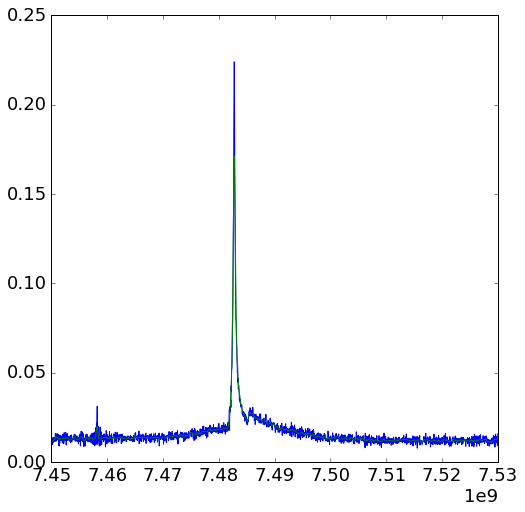

In [54]:
fig_sweet = plt.figure(figsize=(8,8))
plt.plot(freq3, amp3[89][15][:])
plt.plot(freq3, amp3_gauss[89][15][:])

In [55]:
mw_pump3.shape

(87,)

In [56]:
Z3[1].shape

(87,)

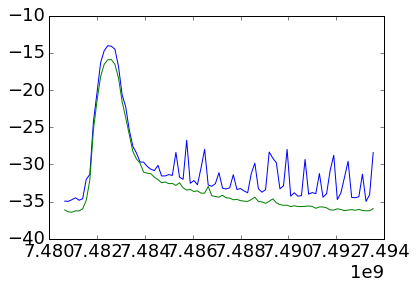

In [57]:
plt.plot(mw_pump3,gaussian_filter1d(Z3[90],0) )
plt.plot(mw_pump3,Z3_gauss[90]) 

In [58]:
indices3 = np.arange(0,len(power_pump3),1)

(7458000000.0, 7522040000.0)

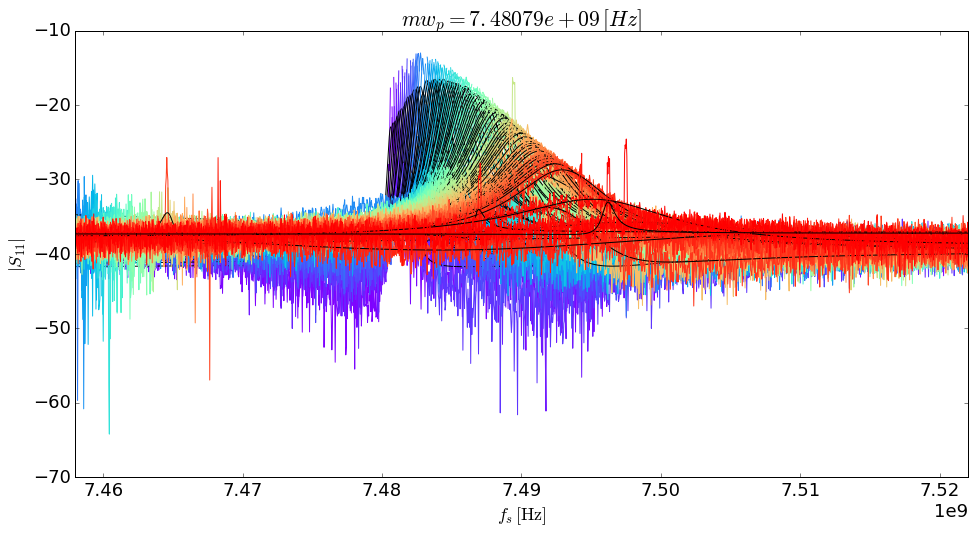

In [293]:
a = 1
#sweet spots only
f_min3 = freq3[200]
f_max3 = freq3[-200]
fr3 = []
Ql3 = []
G1 = []
B1 = []
GB = []
fit_freq3 = _prepare_f_range(freq3,f_min3, f_max3,freq3)
fig3, axes = plt.subplots(figsize = (16,8))
c = color=cm.rainbow(np.linspace(0,1,len(mw_pump3)))
indices = np.arange(0,len(power_pump3),1)
for j in range(len(mw_pump3)):
    #axes.axvline(mw_pump[j], color = 'yellow', lw = 1.)
    mask_p3 = power_pump3 == p_sweet3[j]
    i = int(np.extract(mask_p3,indices3)) 
    amp_buffer3 = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,j,:],0))
    A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(fit_freq3,amp_buffer3, ignoreslope = True)
    fr3.append(fr)
    Ql3.append(Ql)
    lorentzian = (A1+A2*(fit_freq3-fr)+(A3+A4*(fit_freq3-fr))/(1.+4.*Ql**2*((fit_freq3-fr)/fr)**2))
    
    ##gain and bandwidth:    
    G_max = np.max(20.*np.log10(lorentzian)-np.min(20.*np.log10(lorentzian)))
    G1.append(G_max)
    BW = np.absolute(fr/Ql)
    B1.append(BW/np.sqrt(2))
    GB.append(BW*np.sqrt(G_max)/10**6.)
    
    axes.plot(fit_freq3,20.*np.log10(np.ma.masked_array(amp_buffer3, mask(fit_freq3,mw_pump3[j], (freq3[-1]-freq3[0])/(len(freq3)),1.))), label =r'$P_p = {}$'.format(str(power_pump3[i])), color = c[j])
    axes.plot(fit_freq3, 20.*np.log10(lorentzian), color = 'black')
axes.set_title(r'$mw_p = {}\,[Hz]$'.format(str(mw_pump3[a])))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
axes.set_xlim(f_min3,f_max3)
#axes.legend()

In [294]:
GB

[2.3883960378241951,
 2.3738496907803635,
 2.6324141774304652,
 2.7427413375778236,
 2.7446633300517624,
 2.9327606614253638,
 2.9088500924086973,
 3.0676824619403158,
 3.1652342373867439,
 3.2671192763357522,
 3.4500318879872549,
 3.6102643039965989,
 3.7234796959784551,
 3.22818270135524,
 3.6892605536367435,
 3.9258183493811498,
 4.0969374861616501,
 4.514746577451473,
 4.8438885270622158,
 4.8947067384007763,
 5.1856976419744516,
 5.3030180211713329,
 5.6908638221994767,
 5.8388115520621868,
 5.9834905070382716,
 6.3190972364503732,
 6.7192890898527384,
 6.6105813837382827,
 7.0350832752275689,
 7.4330498622007699,
 7.8378038547967677,
 8.11134839520175,
 8.3468084605299548,
 8.7825376275621885,
 9.1876817061205998,
 9.553678029916302,
 10.017783842438401,
 10.51317765959921,
 10.860246129268369,
 10.915221172240898,
 10.848845888007622,
 11.080521235216171,
 11.390041663422053,
 11.986381341654006,
 11.939793846420866,
 12.681068916461628,
 13.598115455165718,
 12.847322385507553,

In [295]:
BW_max = fres*4/(np.sqrt(3)*2*390)/10**6.
print BW_max

22.2203367038


In [296]:
G_tot = np.array(G1)

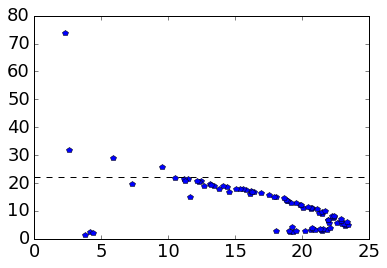

In [297]:
plt.plot(G_tot,np.array(GB), linestyle = "None", marker = 'p')
plt.axhline(BW_max, ls = "--", color = 'black')

### sweet spots only

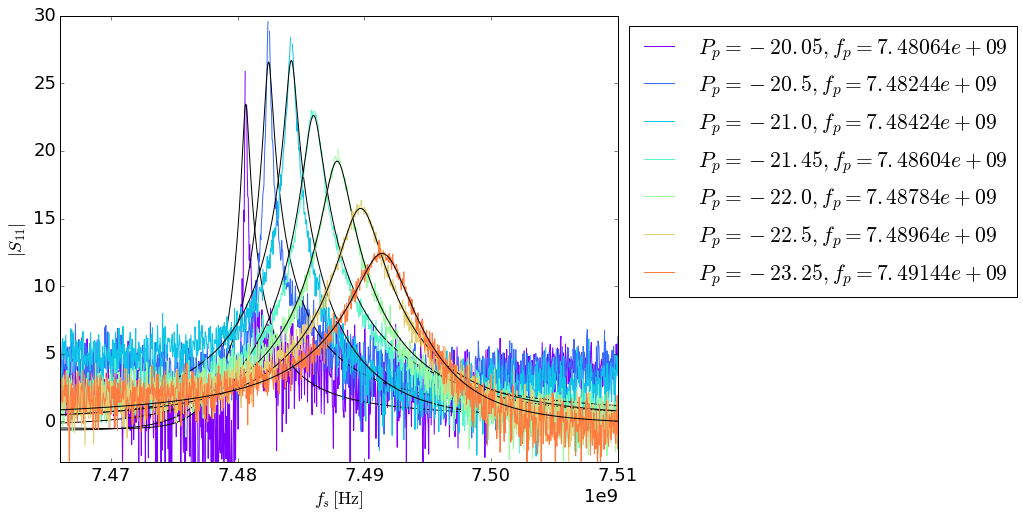

In [457]:
#sweet spots only: for different microwave pump frequencies

a = 1
f_min3 = freq3[400]
f_max3 = freq3[-500]
fr3 = []
Ql3 = []
delta3 = []
G1 = []
B1 = []
GB = []
fit_freq3 = _prepare_f_range(freq3,f_min3, f_max3,freq3)
fig3, axes = plt.subplots(figsize = (10,8))
c = color=cm.rainbow(np.linspace(0,1,len(mw_pump3)))
indices = np.arange(0,len(power_pump3),1)
for f in range(7):
    #axes.axvline(mw_pump[j], color = 'yellow', lw = 1.)
    j = 12*f
    mask_p3 = power_pump3 == p_sweet3[j]
    i = int(np.extract(mask_p3,indices3)) 
    amp_buffer3 = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,j,:],0))
    
    ### Lorentzian fit
    A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(fit_freq3,amp_buffer3, ignoreslope = True)
    fr3.append(fr)
    Ql3.append(Ql)
    A2 = 0.
    fr_pump = mw_pump3[j]
    delta3.append(2.*np.pi*(fr_pump-fres)/(Gamma))
    lorentzian = (A1+A2*(fit_freq3-fr)+(A3+A4*(fit_freq3-fr))/(1.+4.*Ql**2*((fit_freq3-fr)/fr)**2))
    
    ##gain and bandwidth:
    G_max = np.max(20.*np.log10(lorentzian)-np.min(20.*np.log10(lorentzian)))
    G1.append(G_max)
    BW = np.absolute(fr/Ql)
    B1.append(BW)
    GB.append(BW*np.sqrt(G_max))
    
    amplitude_masked = 20.*np.log10(np.ma.masked_array(amp_buffer3, mask(fit_freq3,mw_pump3[j], (freq3[-1]-freq3[0])/(len(freq3)),1.)))
    norm = 10.*np.log10(A1)
    axes.plot(fit_freq3,amplitude_masked-norm, label =r'$P_p = {}, f_p = {}$'.format(str(power_pump3[i]), str(mw_pump3[j])), color = c[j])
    axes.plot(fit_freq3, 10.*np.log10(lorentzian)-norm, color = 'black')
#axes.set_title(r'$mw_p = {}\,[Hz]$'.format(str(mw_pump2[a])))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
axes.set_xlim(f_min3,f_max3)
axes.set_ylim(-3,30)
axes.legend(loc = 'upper left', bbox_to_anchor =  (1.0,1.0))

In [ ]:
# gain bandwidth product
GB

In [61]:
# detuning
delta3

[-1.2107264229886878,
 -1.1209594891391332,
 -1.0311670170438181,
 -0.94137454494850281,
 -0.85160761109894845,
 -0.76181513900363318,
 -0.67202266690831791]

In [62]:
#fig3.savefig('Ivan_gain_curves_w_lorentz.pdf', dpi = 400, bbox_inches = 'tight')

In [63]:
fr3

[7480590352.5900078,
 7482420566.711525,
 7484265725.4893084,
 7485949827.1656713,
 7487855569.9122381,
 7489731373.4124498,
 7491602228.4907389]

### Gain over pump signal detuning

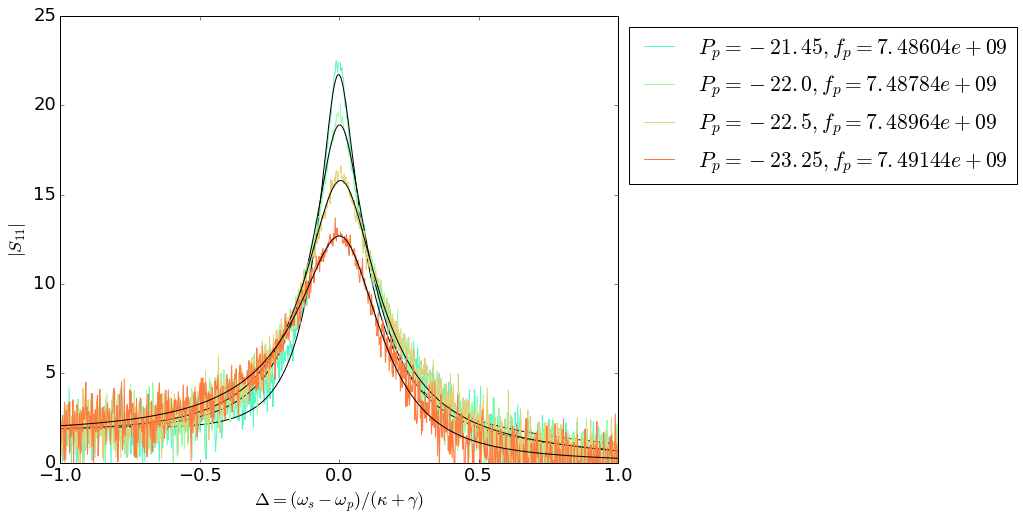

In [64]:
#sweet spots only: for different microwave pump frequencies
#centered to the pump frequency
a = 1
f_min3 = freq3[200]
f_max3 = freq3[-200]
fr3 = []
Ql3 = []
fit_freq3 = _prepare_f_range(freq3,f_min3, f_max3,freq3)
fig3, axes = plt.subplots(figsize = (10,8))
c = color=cm.rainbow(np.linspace(0,1,len(mw_pump3)))
indices = np.arange(0,len(power_pump3),1)
for f in range(4):
    #axes.axvline(mw_pump[j], color = 'yellow', lw = 1.)
    #j = 12*f
    j = 36+12*f
    mask_p3 = power_pump3 == p_sweet3[j]
    i = int(np.extract(mask_p3,indices3)) 
    amp_buffer3 = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,j,:],0))
    A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(fit_freq3,amp_buffer3, ignoreslope = True)
    fr3.append(fr)
    Ql3.append(Ql)
    fr_pump = mw_pump3[j]
    lorentzian = (A1+A2*(fit_freq3-fr)+(A3+A4*(fit_freq3-fr))/(1.+4.*Ql**2*((fit_freq3-fr)/fr)**2))
    amplitude_masked = 20.*np.log10(np.ma.masked_array(amp_buffer3, mask(fit_freq3,mw_pump3[j], (freq3[-1]-freq3[0])/(len(freq3)),1.)))
    axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma,amplitude_masked-np.min(20.*np.log10(lorentzian)), label =r'$P_p = {}, f_p = {}$'.format(str(power_pump3[i]), str(mw_pump3[j])), color = c[j])
    axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma, 20.*np.log10(lorentzian)-np.min(20.*np.log10(lorentzian)), color = 'black')
#axes.set_title(r'$mw_p = {}\,[Hz]$'.format(str(mw_pump2[a])))
axes.set_xlabel(r'$\Delta = (\omega_s-\omega_p)/(\kappa + \gamma)$')
axes.set_ylabel(r'$|S_{11}|$')
#axes.set_xlim(f_min3,f_max3)
axes.set_xlim(-1.0,1.0)
axes.set_ylim(0,25)
axes.legend(loc = 'upper left', bbox_to_anchor =  (1.0,1.0))

In [65]:
f = 5

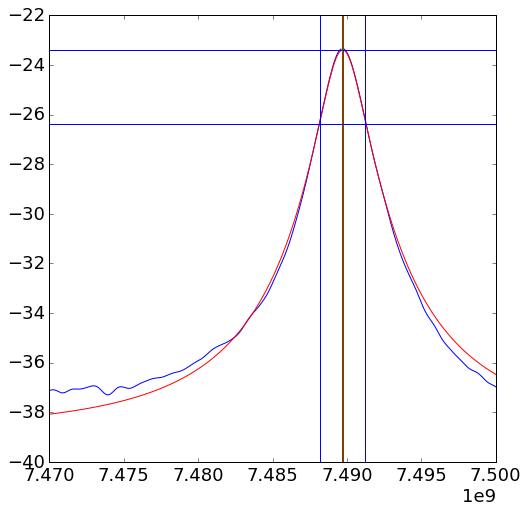

In [416]:
fig_gain = plt.figure(figsize = (8,8))
j = 12*f
mask_p3 = power_pump3 == p_sweet3[j]
i = int(np.extract(mask_p3,indices3)) 
amp_buffer3 = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,j,:],10))
amp_dB = 20.*np.log10(np.ma.masked_array(amp_buffer3, mask(fit_freq3,mw_pump3[j], (freq3[-1]-freq3[0])/(len(freq3)),1.)))
A1, A2, A3, fr, Ql = _fit_lorentzian_sqr(fit_freq3,amp_buffer3, ignoreslope = True)
A4 = 0.
A2 = 0
lorentzian = (A1+A2*(fit_freq3-fr)+(A3+A4*(fit_freq3-fr))/(1.+4.*Ql**2*((fit_freq3-fr)/fr)**2))
plt.plot(fit_freq3, amp_dB )
plt.plot(fit_freq3, 10.*np.log10(lorentzian), color = 'red')
plt.axvline(fr, color = 'red')
plt.axvline(fr-fr/(2*Ql))
plt.axvline(fr+fr/(2*Ql))
plt.xlim(7.47*10**9., 7.50*10**9)
plt.axhline(np.max(10.*np.log10(lorentzian)))
plt.axhline(np.max(10.*np.log10(lorentzian))-3)
plt.axvline(mw_pump3[j], color = 'green')

In [208]:
zero = 20.*np.log10(lorentzian[0])
print zero

-37.3145259159


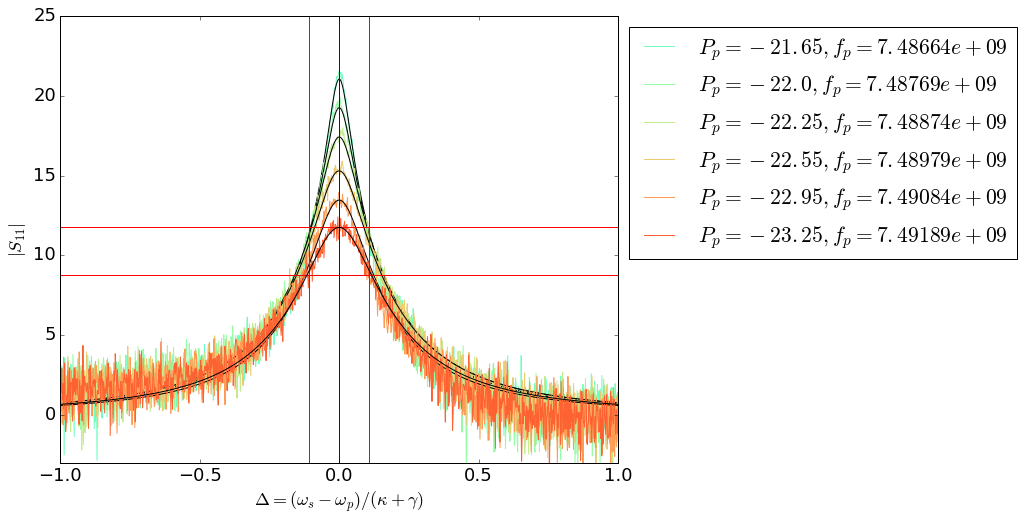

In [479]:
#sweet spots only: for different microwave pump frequencies
#centered to the pump frequency
a = 1
f_min3 = freq3[200]
f_max3 = freq3[-200]
fr3 = []
Ql3 = []
G1 = []
B1 = []
GB = []
fit_freq3 = _prepare_f_range(freq3,f_min3, f_max3,freq3)
fig3, axes = plt.subplots(figsize = (10,8))
c = color=cm.rainbow(np.linspace(0,1,len(mw_pump3)))
indices = np.arange(0,len(power_pump3),1)
for f in range(6):
    #axes.axvline(mw_pump[j], color = 'yellow', lw = 1.)
    #j = 12*f
    j = 40+7*f
    mask_p3 = power_pump3 == p_sweet3[j]
    i = int(np.extract(mask_p3,indices3)) 
    amp_buffer3 = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,j,:],0))
    amp_Lorentz = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,j,:],3))
    fr_pump = mw_pump3[j]
    ## lorentzian fit
    #A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(fit_freq3,amp_buffer3, ignoreslope = True)
    A1, A2, A3, fr, Ql = _fit_lorentzian_sqr(fit_freq3,amp_Lorentz, ignoreslope = True, fr = fr_pump)
    fr3.append(fr)
    Ql3.append(Ql)
    A4 = 0.
    A2 = 0
    lorentzian = (A1+A2*(fit_freq3-fr)+(A3+A4*(fit_freq3-fr_pump))/(1.+4.*Ql**2.*((fit_freq3-fr_pump)/fr_pump)**2))
    
    ##gain and bandwidth:
    G_max = np.max(10.*np.log10(lorentzian/A1))
    G1.append(G_max)
    BW = np.absolute(fr/(Ql))
    B1.append(BW)
    GB.append(BW*np.sqrt(G_max))
    
    amplitude_masked = 20.*np.log10(np.ma.masked_array(amp_buffer3, mask(fit_freq3,mw_pump3[j], (freq3[-1]-freq3[0])/(len(freq3)),1.)))
    axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma,amplitude_masked-10.*np.log10(A1), label =r'$P_p = {}, f_p = {}$'.format(str(power_pump3[i]), str(mw_pump3[j])), color = c[j])

    '''
    if f == 0.:
        axes.axvline(2.*np.pi*(-BW/2)/Gamma, color = 'red')
        axes.axvline(2.*np.pi*(+BW/2)/Gamma, color = 'red')
        axes.axhline(G_max, color = 'red')
        axes.axhline(G_max-3, color = 'red')
        axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma, 20.*np.log10(lorentzian)-zero, color = 'black')
        axes.axvline(2.*np.pi*(fr-fr_pump)/Gamma, color = 'blue')
    '''
    
    if f == 5.:
        axes.axvline(2.*np.pi*(-BW/2.)/Gamma, color = 'red')
        axes.axvline(2.*np.pi*(+BW/2.)/Gamma, color = 'red')
        axes.axhline(G_max, color = 'red')
        axes.axhline(G_max-3, color = 'red')
        axes.axvline(2.*np.pi*(fr-fr_pump)/Gamma, color = 'blue')
        #DELTA = 2.*np.pi*(fit_freq3-fr_pump)/Gamma
        #lorentz2 = G_max/(1+(DELTA*(Gamma/(2*np.pi*BW)))**2.)
        #axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma, lorentz2)
    axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma, 10.*np.log10(lorentzian/A1), color = 'black')
    #axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma,amplitude_masked-np.min(20.*np.log10(lorentzian)), label =r'$P_p = {}, f_p = {}$'.format(str(power_pump3[i]), str(mw_pump3[j])), color = c[j])
    #axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma, 20.*np.log10(lorentzian)-np.min(20.*np.log10(lorentzian)), color = 'black')
    
    #identical normalization
    #axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma, 20.*np.log10(lorentzian)-zero, color = 'black')

axes.set_xlabel(r'$\Delta = (\omega_s-\omega_p)/(\kappa + \gamma)$')
axes.set_ylabel(r'$|S_{11}|$')
axes.set_xlim(-1.0,1.0)
axes.set_ylim(-3,25)
axes.legend(loc = 'upper left', bbox_to_anchor =  (1.0,1.0))

In [463]:
A1

0.00013035668979726085

In [464]:
zero

-37.314525915872061

In [465]:
20.*np.log10(A1)

-77.697333525818792

In [466]:
print 2.*np.pi*(fr-fr_pump)/Gamma

-0.000819214898326


In [467]:
#fig3.savefig('Ivan_gain_curves_w_lorentz_DELTA.pdf', dpi = 400, bbox_inches = 'tight')

In [468]:
20.*np.log10(A1)

-77.697333525818792

In [469]:
np.array(B1)/10**6.

array([ 1.45029727,  1.82050682,  2.36113133,  3.04190491,  3.30271137,
        4.33357778])

In [470]:
G1

[21.053047685643858,
 19.257330126956699,
 17.419960935963889,
 15.294407201008937,
 13.460728147288098,
 11.747651861936298]

In [471]:
GB

[6654486.0185894007,
 7988961.8542227596,
 9854707.3707095832,
 11896301.378372245,
 12117273.148761395,
 14853271.856623417]

In [472]:
GB

[6654486.0185894007,
 7988961.8542227596,
 9854707.3707095832,
 11896301.378372245,
 12117273.148761395,
 14853271.856623417]

In [473]:
BW_max = fres*4/(np.sqrt(3)*2*390)/10**6.
print BW_max

22.2203367038


(10, 22)

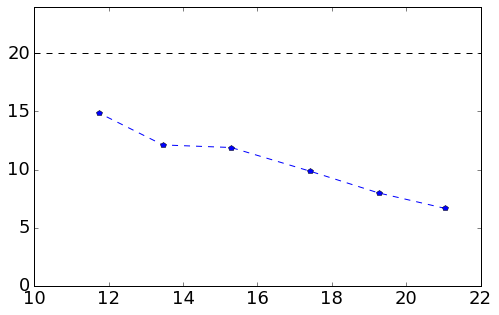

In [481]:
fig_BW = plt.figure(figsize = (8,5))
plt.axhline(Gamma/(2.*np.pi*10**6.), linestyle = "--", color = 'black')
plt.plot(G1,np.array(GB)/10**6., linestyle = '--', marker = 'p')
plt.ylim(0,24)
plt.xlim(10,22)

In [482]:
fig_BW.savefig('GBW.pdf', dpi = 400, bbox_to_anchor = 'tight')

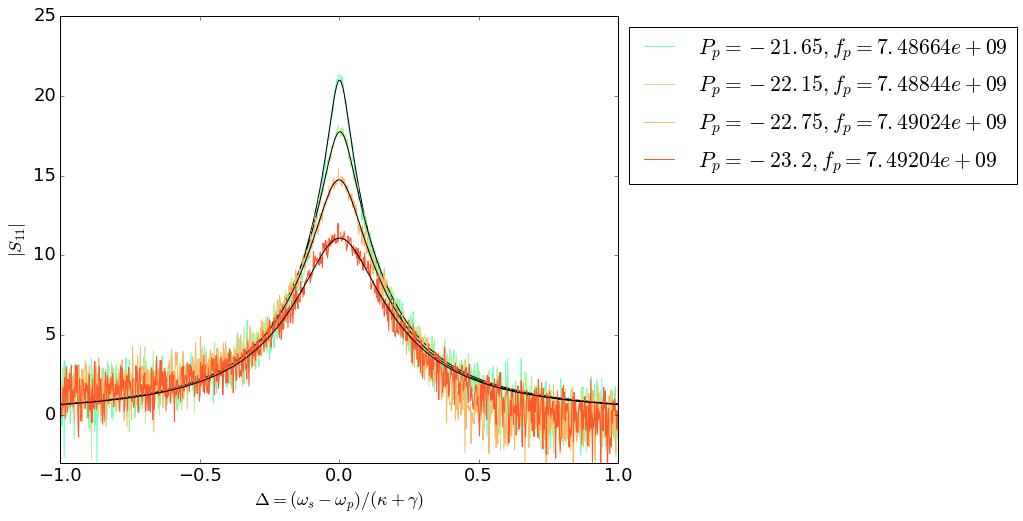

In [477]:
#sweet spots only: for different microwave pump frequencies
#centered to the pump frequency
a = 1
f_min3 = freq3[200]
f_max3 = freq3[-200]
fr3 = []
Ql3 = []
delta3 = []
G = []
G1 = []
B1 = []
GB = []
fit_freq3 = _prepare_f_range(freq3,f_min3, f_max3,freq3)
fig3, axes = plt.subplots(figsize = (10,8))
c = color=cm.rainbow(np.linspace(0,1,len(mw_pump3)))
indices = np.arange(0,len(power_pump3),1)
for f in range(4):
    #axes.axvline(mw_pump[j], color = 'yellow', lw = 1.)
    #j = 12*f
    j = 40+12*f
    ####data preparation:
    mask_p3 = power_pump3 == p_sweet3[j]
    i = int(np.extract(mask_p3,indices3)) 
    amp_buffer3 = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,j,:],0))
    amp_Lorentz = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,j,:],0))
    
    
    ###skewed lorentzian fit:
    A1, A2, A3, fr, Ql = _fit_lorentzian_sqr(fit_freq3,amp_Lorentz, ignoreslope = True)
    A2 = 0.
    A4 = 0
    fr3.append(fr)   # resonance frequency
    Ql3.append(Ql)   #loaded quality factor
    fr_pump = mw_pump3[j]   #pump tone frequency
    delta3.append(2.*np.pi*(fr_pump-fres)/(Gamma)) #detuning from resonance frequency  
    lorentzian = (A1+A2*(fit_freq3-fr)+(A3+A4*(fit_freq3-fr))/(1.+4.*Ql**2*((fit_freq3-fr)/fr)**2))
    
    
    ##gain and bandwidth:
    G_max = np.max(10.*np.log10(lorentzian/A1))
    G1.append(G_max)
    BW = np.absolute(fr/(Ql))
    B1.append(BW)
    GB.append(BW*np.sqrt(G_max))
    
    if f == 4.:
        axes.axvline(2.*np.pi*(-BW/2.)/Gamma, color = 'black')
        axes.axvline(2.*np.pi*(+BW/2.)/Gamma, color = 'black')
        axes.axhline(G_max, color = 'red')
        axes.axhline(G_max-3, color = 'red')
        #axes.axvline(2.*np.pi*(fr-fr_pump)/Gamma, color = 'blue')
        #DELTA = 2.*np.pi*(fit_freq3-fr_pump)/Gamma
        #lorentz2 = G_max/(1+(DELTA*(Gamma/(2*np.pi*BW)))**2.)
        #axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma, lorentz2)
    
    amplitude_masked = 20.*np.log10(np.ma.masked_array(amp_buffer3, mask(fit_freq3,mw_pump3[j], (freq3[-1]-freq3[0])/(len(freq3)),1.)))
    
    #individual normalization
    #axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma,amplitude_masked-np.min(20.*np.log10(lorentzian)), label =r'$P_p = {}, f_p = {}$'.format(str(power_pump3[i]), str(mw_pump3[j])), color = c[j])
    #axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma, 20.*np.log10(lorentzian)-np.min(20.*np.log10(lorentzian)), color = 'black')
    
    #identical normalization
    axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma,amplitude_masked-10.*np.log10(A1), label =r'$P_p = {}, f_p = {}$'.format(str(power_pump3[i]), str(mw_pump3[j])), color = c[j])
    axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma, 10.*np.log10(lorentzian/A1), color = 'black')

    
#axes.set_title(r'$mw_p = {}\,[Hz]$'.format(str(mw_pump2[a])))
axes.set_xlabel(r'$\Delta = (\omega_s-\omega_p)/(\kappa + \gamma)$')
axes.set_ylabel(r'$|S_{11}|$')
#axes.set_xlim(f_min3,f_max3)
axes.set_xlim(-1.0,1.0)
axes.set_ylim(-3,25)
axes.legend(loc = 'upper left', bbox_to_anchor =  (1.0,1.0))

In [478]:
fig3.savefig('Ivan_gain_curves_w_lorentz_DELTA2.pdf', dpi = 400, bbox_inches = 'tight')

In [444]:
Ql3

[5286.5644218640873,
 3468.5189428635981,
 -2466.5016969567114,
 1599.829589765754]

In [445]:
Ql2

392

In [446]:
BW_max = fres*4/(np.sqrt(3)*2*390)/10**6.
print BW_max

22.2203367038


In [447]:
Gamma/(2.*np.pi)

20048362.162131868

In [448]:
2*Gamma/(2.*np.pi*10**6)

40.096724324263732

In [449]:
np.array(GB)/10**6.

array([  4.39086554,   6.18568046,   7.81816265,  10.37440062])

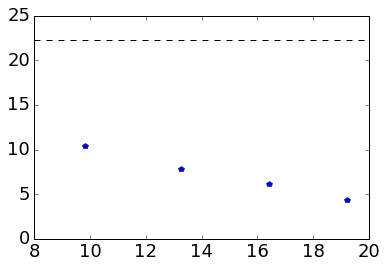

In [450]:
plt.plot(G1,np.array(GB)/10**6., linestyle = 'None', marker = 'p')
plt.axhline(BW_max, ls = "--", color = 'black')

In [406]:
20.*np.log10(A3)-np.min(20.*np.log10(lorentzian))

7.741046210892776

In [70]:
delta3

[-0.91144372091673109,
 -0.82167678706717662,
 -0.73188431497186146,
 -0.6421173811223071]

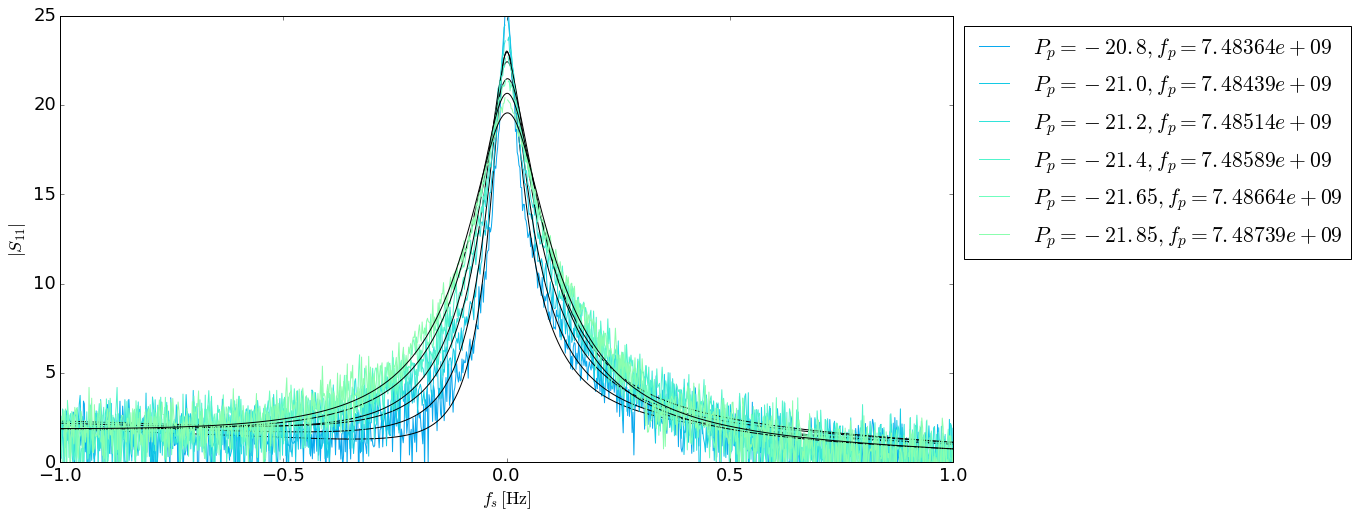

In [72]:
#sweet spots only: for different microwave pump frequencies
#centered to the pump frequency
a = 1
f_min3 = freq3[200]
f_max3 = freq3[-200]
fr3 = []
Ql3 = []
fit_freq3 = _prepare_f_range(freq3,f_min3, f_max3,freq3)
fig3, axes = plt.subplots(figsize = (16,8))
c = color=cm.rainbow(np.linspace(0,1,len(mw_pump3)))
indices = np.arange(0,len(power_pump3),1)
for f in range(6):
    #axes.axvline(mw_pump[j], color = 'yellow', lw = 1.)
    #j = 12*f
    j = 20+5*f
    mask_p3 = power_pump3 == p_sweet3[j]
    i = int(np.extract(mask_p3,indices3)) 
    amp_buffer3 = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,j,:],0))
    A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(fit_freq3,amp_buffer3, ignoreslope = True)
    fr3.append(fr)
    Ql3.append(Ql)
    fr_pump = mw_pump3[j]
    lorentzian = (A1+A2*(fit_freq3-fr)+(A3+A4*(fit_freq3-fr))/(1.+4.*Ql**2*((fit_freq3-fr)/fr)**2))
    amplitude_masked = 20.*np.log10(np.ma.masked_array(amp_buffer3, mask(fit_freq3,mw_pump3[j], (freq3[-1]-freq3[0])/(len(freq3)),1.)))
    axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma,amplitude_masked-np.min(20.*np.log10(lorentzian)), label =r'$P_p = {}, f_p = {}$'.format(str(power_pump3[i]), str(mw_pump3[j])), color = c[j])
    axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma, 20.*np.log10(lorentzian)-np.min(20.*np.log10(lorentzian)), color = 'black')
#axes.set_title(r'$mw_p = {}\,[Hz]$'.format(str(mw_pump2[a])))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
#axes.set_xlim(f_min3,f_max3)
axes.set_xlim(-1.0,1.0)
axes.set_ylim(0,25)
axes.legend(loc = 'upper left', bbox_to_anchor =  (1.0,1.0))

### response for a fixed pump power

In [73]:
mw_pump3.shape

(87,)

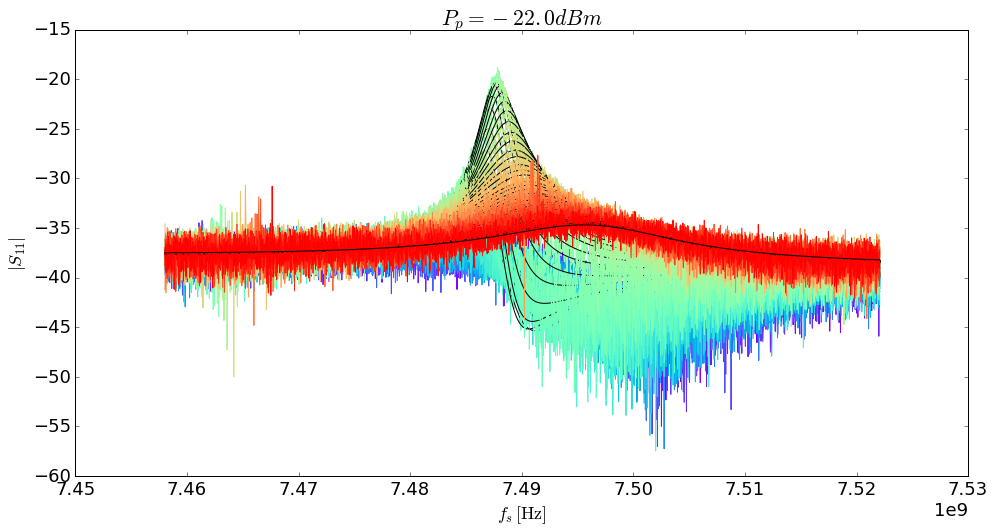

In [74]:
a = 1
A_max = []
fr3 = []
Ql3 = []
delta3 = []
#sweet spots only
fig, axes = plt.subplots(figsize = (16,8))
#pump power values fixed to p
p3 = -22.0
mask_p3 = power_pump3 == p3
#extract indice of p in the power array
i = int(np.extract(mask_p3,indices3))
#set range of the microwave pump tone 
mw_min3 = mw_pump3[10]
mw_max3 = mw_pump3[-10]
fit_mw_pump3 = _prepare_f_range(mw_pump3, mw_min3, mw_max3, mw_pump3)
#colorbar
c = color=cm.rainbow(np.linspace(0,1,len(fit_mw_pump3)))
for j in range(len(fit_mw_pump3)):
    #determine indec of the microwave tone 
    mask_mw3 = mw_pump3 == fit_mw_pump3[j]
    r = int(np.extract(mask_mw3,indices3)) 
    amp_buffer3 = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,r,:],0))
    #lorentzian fit function
    A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(freq3,amp3[i,r,:], ignoreslope = True)
    fr3.append(fr)
    Ql3.append(Ql)
    fr_pump = mw_pump3[j]
    delta3.append(2.*np.pi*(fr_pump-fres)/(Gamma))
    lorentzian = (A1+A2*(fit_freq3-fr)+(A3+A4*(fit_freq3-fr))/(1.+4.*Ql**2*((fit_freq3-fr)/fr)**2))
    A_max.append(np.max(lorentzian))
    amplitude_masked = 20.*np.log10(np.ma.masked_array(amp_buffer3, mask(fit_freq3,mw_pump3[j], (freq3[-1]-freq3[0])/(len(freq3)),1.)))
    #axes.plot(freq3,20.*np.log10(gaussian_filter1d(amp3[i,r,:],0)), label =r'$P_p = {}$'.format(str(power_pump3[i])), color = c[j])
    axes.plot(fit_freq3,amplitude_masked, label =r'$P_p = {}, f_p = {}$'.format(str(power_pump3[i]), str(mw_pump3[j])), color = c[j])
    #axes.plot(freq3,20.*np.log10(gaussian_filter1d(amp3[i,r,:],0)), label =r'$P_p = {}$'.format(str(power_pump3[i])), color = c[j])
    axes.plot(fit_freq3, 20.*np.log10(lorentzian), color = 'black')
axes.set_title(r'$P_p = {} dBm$'.format(str(p3)))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
#axes.legend()

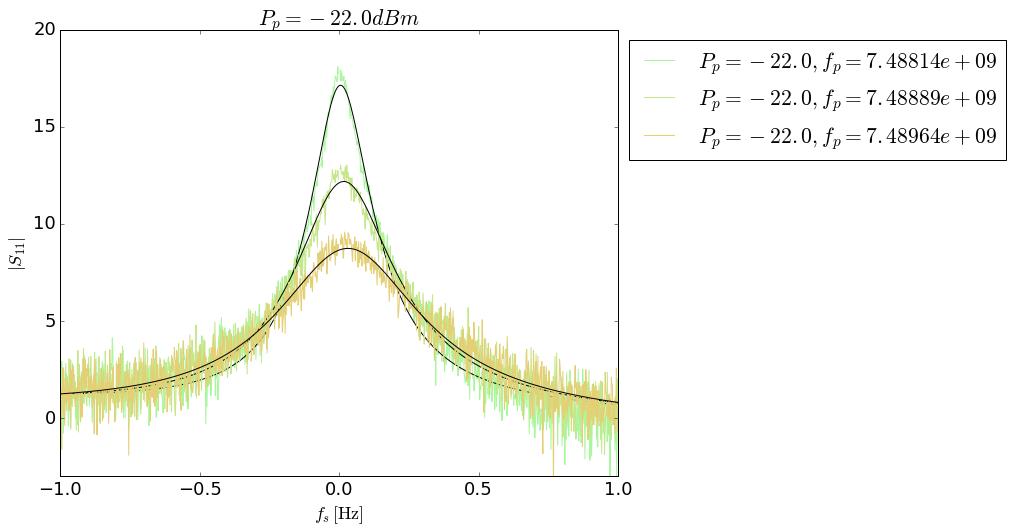

In [166]:
a = 1
A_max = []
fr3 = []
Ql3 = []
delta3 = []
#sweet spots only
fig, axes = plt.subplots(figsize = (10,8))
#pump power values fixed to p
p3 = -22.0
mask_p3 = power_pump3 == p3
#extract indice of p in the power array
i = int(np.extract(mask_p3,indices3))
#colorbar
c = color=cm.rainbow(np.linspace(0,1,len(mw_pump3)))
for j in range(3):
    #determine indec of the microwave tone 
    f = 50+5*j
    mask_mw3 = mw_pump3 == mw_pump3[f]
    r = int(np.extract(mask_mw3,indices3)) 
    amp_buffer3 = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,r,:],0))
    #lorentzian fit function
    A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(freq3,amp3[i,r,:], ignoreslope = True)
    fr3.append(fr)
    Ql3.append(Ql)
    fr_pump = mw_pump3[f]
    delta3.append(2.*np.pi*(fr_pump-fres)/(Gamma))
    lorentzian = (A1+A2*(fit_freq3-fr)+(A3+A4*(fit_freq3-fr))/(1.+4.*Ql**2*((fit_freq3-fr)/fr)**2))
    A_max.append(np.max(lorentzian))
    amplitude_masked = 20.*np.log10(np.ma.masked_array(amp_buffer3, mask(fit_freq3,mw_pump3[f], (freq3[-1]-freq3[0])/(len(freq3)),1.)))
    #axes.plot(freq3,20.*np.log10(gaussian_filter1d(amp3[i,r,:],0)), label =r'$P_p = {}$'.format(str(power_pump3[i])), color = c[j])
    norm = np.min(20.*np.log10(lorentzian))
    axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma,amplitude_masked-norm, label =r'$P_p = {}, f_p = {}$'.format(str(power_pump3[i]), str(mw_pump3[f])), color = c[f])
    #axes.plot(freq3,20.*np.log10(gaussian_filter1d(amp3[i,r,:],0)), label =r'$P_p = {}$'.format(str(power_pump3[i])), color = c[j])
    axes.plot(2.*np.pi*(fit_freq3-fr_pump)/Gamma, 20.*np.log10(lorentzian)-norm, color = 'black')
axes.set_title(r'$P_p = {} dBm$'.format(str(p3)))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
axes.set_xlim(-1.0,1.0)
axes.set_ylim(-3,20)
axes.legend(loc = 'upper left', bbox_to_anchor =  (1.0,1.0))

In [76]:
delta3

[-0.83664219908306259,
 -0.79922866904334788,
 -0.76181513900363318,
 -0.72440160896391848,
 -0.68698807892420377]

In [77]:
fig.savefig('Ivan_gain_curves_w_lorentz_DELTA_Pconst.pdf', dpi = 400, bbox_inches = 'tight')

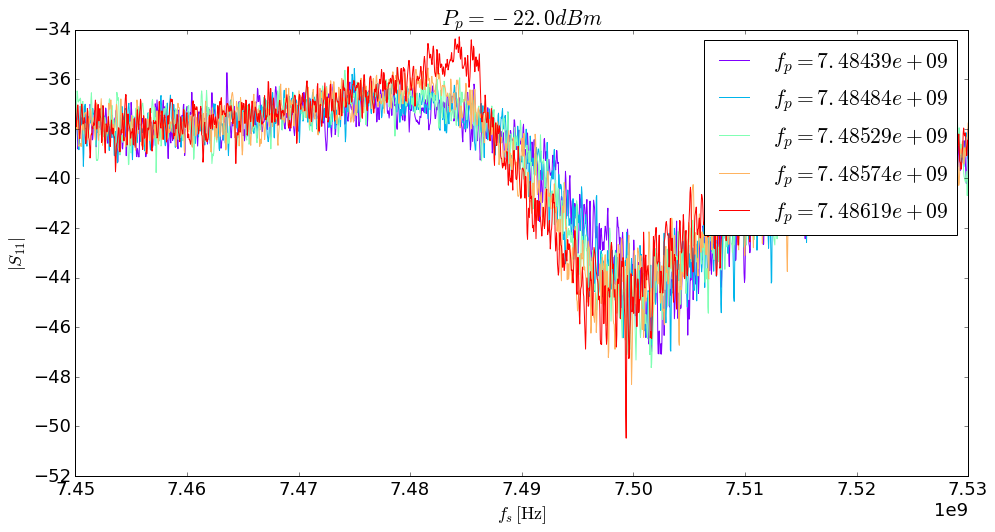

In [78]:
fig_sweet, axes = plt.subplots(figsize = (16,8))
numb = 5
c = color=cm.rainbow(np.linspace(0,1,numb))
for j in range(numb):
    r = 25+3*j
    axes.plot(freq3,20.*np.log10(gaussian_filter1d(amp3[i,r,:],1)), label =r'$f_p = {}$'.format(str(mw_pump3[r])), color = c[j])
    #axes.plot(fit_freq3, 20.*np.log10(lorentzian), color = 'black')
axes.set_title(r'$P_p = {} dBm$'.format(str(p3)))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
axes.legend()

### response for a fixed pump frequency

In [79]:
power_pump3[80]

-21.0

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: invalid value encountered in log10


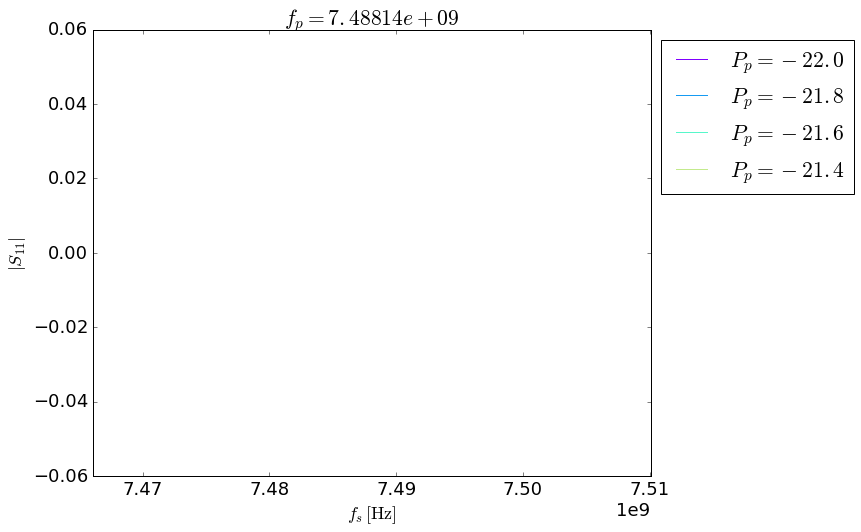

In [491]:
a = 1
A_max = []
fr3 = []
Ql3 = []
f_min3 = freq3[400]
f_max3 = freq3[-500]
fit_freq3 = _prepare_f_range(freq3, f_min3, f_max3, freq3)
#sweet spots only
fig, axes = plt.subplots(figsize = (10,8))
r = 50
mask_mw = power_pump3 == mw_pump3[r]
#set range of the microwave pump tone 
#colorbar
c = color=cm.rainbow(np.linspace(0,1,20))
for j in range(4):
    i = 60+4*j
    amp_buffer3 = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,r,:],0))
    amp_filter = np.ma.masked_array(amp_buffer3, mask(fit_freq3,mw_pump3[f], (freq3[-1]-freq3[0])/(len(freq3)),1.))
    #lorentzian fit function
    A1, A2, A3, fr, Ql = _fit_lorentzian_sqr(fit_freq3,amp_filter, ignoreslope = True)
    fr3.append(fr)
    Ql3.append(Ql)
    A1 = 0.
    A4 = 0.
    lorentzian = (A1+A2*(fit_freq3-fr)+(A3+A4*(fit_freq3-fr))/(1.+4.*Ql**2*((fit_freq3-fr)/fr)**2))
    #norm = (10.*np.log10(A1))
    axes.plot(fit_freq3,20.*np.log10(amp_filter)-norm, label =r'$P_p = {}$'.format(str(power_pump3[i])), color = c[4*j])
    axes.plot(fit_freq3, 10.*np.log10(lorentzian)-norm, color = 'black')
axes.set_title(r'$f_p = {} $'.format(str(mw_pump3[r])))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
axes.set_xlim(fit_freq3[0], fit_freq3[-1])
#axes.set_ylim(-3,20)
axes.legend(loc = 'upper left', bbox_to_anchor = (1.0,1.0))

In [81]:
#fig.savefig('Ivan_gain_curves_w_lorentz_fp_const.pdf', dpi = 400, bbox_inches = 'tight')

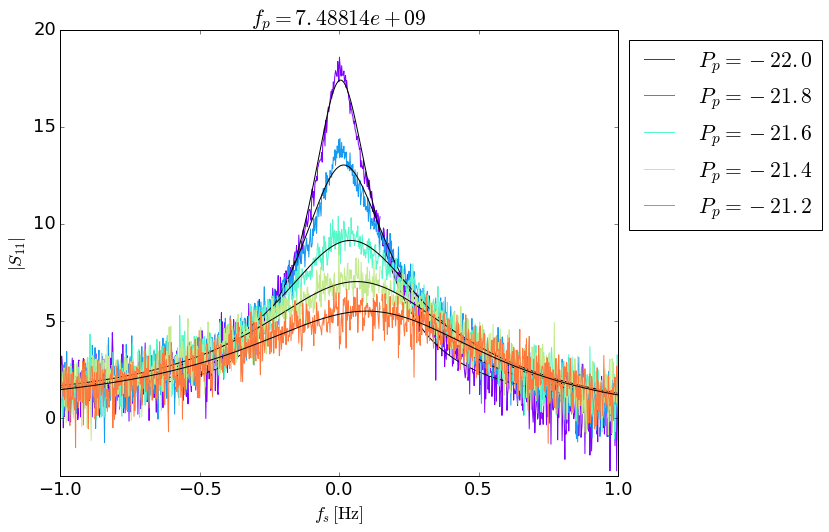

In [82]:
a = 1
A_max = []
fr3 = []
Ql3 = []
f_min3 = freq3[0]
f_max3 = freq3[-1]
fit_freq3 = _prepare_f_range(freq3, f_min3, f_max3, freq3)
#sweet spots only
fig, axes = plt.subplots(figsize = (10,8))
r = 50
mask_mw = power_pump3 == mw_pump3[r]
#set range of the microwave pump tone 
#colorbar
c = color=cm.rainbow(np.linspace(0,1,20))
for j in range(5):
    i = 60+4*j
    amp_buffer3 = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,r,:],0))
    amp_filter = np.ma.masked_array(amp_buffer3, mask(fit_freq3,mw_pump3[f], (freq3[-1]-freq3[0])/(len(freq3)),1.))
    #lorentzian fit function
    A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(fit_freq3,amp_filter, ignoreslope = True)
    fr3.append(fr)
    Ql3.append(Ql)
    lorentzian = (A1+A2*(fit_freq3-fr)+(A3+A4*(fit_freq3-fr))/(1.+4.*Ql**2*((fit_freq3-fr)/fr)**2))
    norm = np.min(20.*np.log10(lorentzian))
    axes.plot(2.*np.pi*(fit_freq3-mw_pump3[r])/Gamma,20.*np.log10(amp_filter)-norm, label =r'$P_p = {}$'.format(str(power_pump3[i])), color = c[4*j])
    axes.plot(2.*np.pi*(fit_freq3-mw_pump3[r])/Gamma, 20.*np.log10(lorentzian)-norm, color = 'black')
axes.set_title(r'$f_p = {} $'.format(str(mw_pump3[r])))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
axes.set_xlim(-1.0, 1.0)
axes.set_ylim(-3,20)
axes.legend(loc = 'upper left', bbox_to_anchor = (1.0,1.0))

In [83]:
#fig.savefig('Ivan_gain_curves_w_lorentz_fp_const_DELTA.pdf', dpi = 400, bbox_inches = 'tight')

In [84]:
delta_crit = -16.79e6

In [85]:
fres+delta_crit

7488126665.8073397

In [86]:
mw_pump3[49]

7.4879933e+09

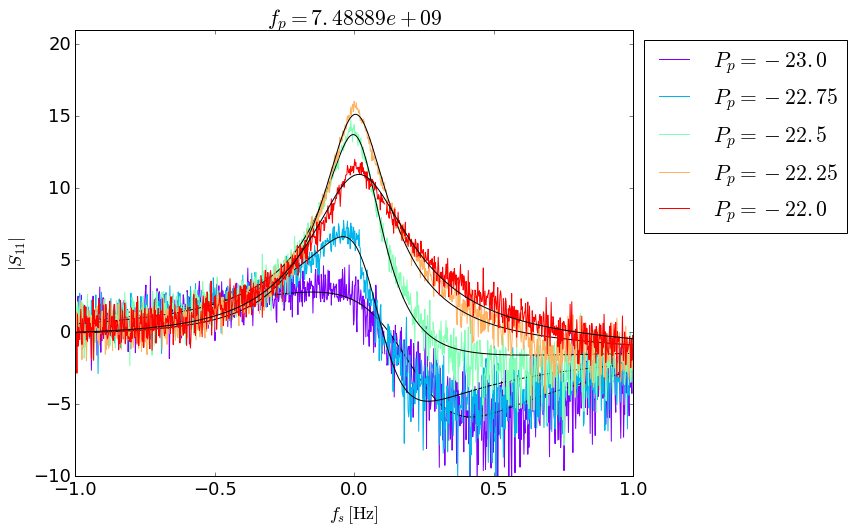

In [87]:
a = 1
A_max = []
fr3 = []
Ql3 = []
f_min3 = freq3[0]
f_max3 = freq3[-1]
norm = None
fit_freq3 = _prepare_f_range(freq3, f_min3, f_max3, freq3)
#sweet spots only
fig_loss, axes = plt.subplots(figsize = (10,8))
r = 55
mask_mw = power_pump3 == mw_pump3[r]
#set range of the microwave pump tone 
#colorbar
c = color=cm.rainbow(np.linspace(0,1,5))
for j in range(5):
    i = 40+5*j
    amp_buffer3 = _prepare_f_range(freq3,f_min3, f_max3,gaussian_filter1d(amp3[i,r,:],0))
    amp_filter = np.ma.masked_array(amp_buffer3, mask(fit_freq3,mw_pump3[f], (freq3[-1]-freq3[0])/(len(freq3)),1.))
    #lorentzian fit function
    A1, A2, A3, A4, fr, Ql = _fit_skewed_lorentzian(fit_freq3,amp_filter, ignoreslope = True)
    fr3.append(fr)
    Ql3.append(Ql)
    lorentzian = (A1+A2*(fit_freq3-fr)+(A3+A4*(fit_freq3-fr))/(1.+4.*Ql**2*((fit_freq3-fr)/fr)**2))
    #if norm == None:
        #norm = np.min(20.*np.log10(lorentzian))
    norm = 20.*np.log10(lorentzian[0])
    axes.plot(2.*np.pi*(fit_freq3-mw_pump3[r])/Gamma,20.*np.log10(amp_filter)-norm, label =r'$P_p = {}$'.format(str(power_pump3[i])), color = c[j])
    axes.plot(2.*np.pi*(fit_freq3-mw_pump3[r])/Gamma, 20.*np.log10(lorentzian)-norm, color = 'black')
axes.set_title(r'$f_p = {} $'.format(str(mw_pump3[r])))
axes.set_xlabel(r'$f_s\, [\mathrm{Hz}]$')
axes.set_ylabel(r'$|S_{11}|$')
axes.set_xlim(-1.0, 1.0)
axes.set_ylim(-10,21)
axes.legend(loc = 'upper left', bbox_to_anchor = (1.0,1.0))

In [88]:
fig_loss.savefig('Ivan_gain_curves_w_lorentz_fp_const_DELTA_loss.pdf', dpi = 400, bbox_inches = 'tight')